Im ersten Teil der Analyse habe ich die 10.000 Hits aus df1 mit den Songtexten aus df2 zusammengeführt und etwa 6000 Songs bekommen, df2 wurde bereinigt und es bleiben noch etwa 800.000 Songs. 

Im ersten Teil bereite ich die Songtexte für die Analyse vor, bestimme die Sprachen mithilfe von fasttext und benutze dann spacy, um sie in eine standardisierte Form zu bringen und linguistische Zusammenhänge im Text zu finden. Da dies sehr rechenaufwendig ist, speichere ich die Zwischenschritte in eine neue .csv-Datei, mit der ich dann die Analysen im zweiten Teil angehe.

In diesem Teil der Analyse schaue ich mir dann die Songtexte an, die Themen, die Komplexität der Texte und die Stimmung. 
Zum Abschluss vergleiche ich die beiden Datensätze und versuche herauszufinden, wie sich Hits von normale-erfolgreichen Songs unterscheiden.

# Teil 3.1: Textverarbeitung

## Sprachen feststellen

Zuerst überprüfe ich, in welchen Sprachen die Songs vorliegen. Dafür gibt es verschiedene "Spracherkennungs"-Bibliotheken. Ich benutze hier fasttext, da es relativ schnell und sicher in der Erkennung ist. 
Um den Prozess zu beschleunigen, werden nur die ersten 2000 Zeichen eingelesen und die Texte werden vorverarbeitet - Texte, die leer sind, oder im falschen Format vorliegen, werden als leerer String zurückgegeben. Außerdem werden Zeilenumbrüche (\n, \r) aus den Texten rausgeworfen.
Da fasttext schneller in batches arbeitet, werden 

In [1]:
import pandas as pd

df3 = pd.read_csv("df_merged.csv")
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             5999 non-null   object 
 1   Track Name            5999 non-null   object 
 2   Artist URI(s)         5999 non-null   object 
 3   Artist Name(s)        5999 non-null   object 
 4   Album URI             5999 non-null   object 
 5   Album Name            5999 non-null   object 
 6   Album Artist URI(s)   5999 non-null   object 
 7   Album Artist Name(s)  5999 non-null   object 
 8   Album Release Date    5999 non-null   object 
 9   Album Image URL       5999 non-null   object 
 10  Disc Number           5999 non-null   int64  
 11  Track Number          5999 non-null   int64  
 12  Track Duration (ms)   5999 non-null   int64  
 13  Track Preview URL     5989 non-null   object 
 14  Explicit              5999 non-null   bool   
 15  Popularity           

In [2]:
import os
import gc
import pandas as pd
import fasttext
from tqdm import tqdm

CSV_PATH = "df_merged.csv"
TEXT_COL = "lyrics"
CHUNKSIZE = 50000
BATCH_SIZE = 50000
MAX_CHARS = 2000
PROB_THRESHOLD = 0.6
BIN_PATH = "lid.176.bin"
FTZ_PATH = "lid.176.ftz"

def load_model():
    path = BIN_PATH if os.path.exists(BIN_PATH) else FTZ_PATH
    print("Lade Modell:", path)
    model = fasttext.load_model(path)
    print("Modell geladen.")
    return model

model = load_model()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text[:MAX_CHARS].replace("\n", " ").replace("\r", " ")

def predict_batch_texts(texts):
    samples = [clean_text(t) for t in texts]
    nonempty_idx = [i for i, s in enumerate(samples) if s]
    langs = [None] * len(samples)
    probs = [0.0] * len(samples)

    if nonempty_idx:
        batch = [samples[i] for i in nonempty_idx]
        labels_list, probs_list = model.predict(batch, k=1)
        for idx, lbls, p in zip(nonempty_idx, labels_list, probs_list):
            lang = lbls[0].replace("__label__", "")
            prob = float(p[0])
            langs[idx] = lang if prob >= PROB_THRESHOLD else None
            probs[idx] = prob
    return langs, probs

#lf = pl.read_csv(CSV_PATH, with_column_types_overwrite=False)  # inferiert
reader = pd.read_csv(CSV_PATH, chunksize=CHUNKSIZE, low_memory=False, dtype={TEXT_COL: str})
chunks_out = []  # hier sammeln

processed = 0
for chunk in tqdm(reader, desc="Verarbeite Chunks"):
    if TEXT_COL not in chunk.columns:
        raise ValueError(f"Spalte '{TEXT_COL}' nicht gefunden.")

    langs_all = []
    probs_all = []
    for i in range(0, len(chunk), BATCH_SIZE):
        texts = chunk[TEXT_COL].fillna("").iloc[i:i+BATCH_SIZE].tolist()
        langs, probs = predict_batch_texts(texts)
        langs_all.extend(langs)
        probs_all.extend(probs)

    chunk = chunk.copy()  # sicher, um SettingWithCopy-Probleme zu vermeiden
    chunk['language'] = langs_all
    chunk['language_prob'] = probs_all

    chunks_out.append(chunk)  # Chunk im Speicher behalten

    processed += len(chunk)
    print(f"Verarbeitet: {processed} Einträge, Chunk ~{chunk.memory_usage(deep=True).sum()/1024**2:.1f} MB")

    del chunk, langs_all, probs_all
    gc.collect()

# Komplettes DataFrame aus Chunks
df3_l = pd.concat(chunks_out, ignore_index=True)
#print(f"Fertig. Insgesamt verarbeitet: {len(df_full)} Einträge.")

# Optional: free chunk list if not needed
del chunks_out
gc.collect()


Lade Modell: lid.176.bin
Modell geladen.


Verarbeite Chunks: 1it [00:01,  1.04s/it]

Verarbeitet: 5999 Einträge, Chunk ~32.0 MB


0

In [3]:
import os
import gc
import polars as pl
import pandas as pd
import fasttext
from tqdm import tqdm

PARQUET_PATH = "df_merged.parquet"
TEXT_COL = "lyrics"
CHUNKSIZE = 50000
BATCH_SIZE = 50000
MAX_CHARS = 2000
PROB_THRESHOLD = 0.6
BIN_PATH = "lid.176.bin"
FTZ_PATH = "lid.176.ftz"
OUT_PARQUET = "df_merged_lang.parquet"

def load_model():
    path = BIN_PATH if os.path.exists(BIN_PATH) else FTZ_PATH
    print("Lade Modell:", path)
    model = fasttext.load_model(path)
    print("Modell geladen.")
    return model

model = load_model()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text[:MAX_CHARS].replace("\n", " ").replace("\r", " ")

def predict_batch_texts(texts):
    samples = [clean_text(t) for t in texts]
    nonempty_idx = [i for i, s in enumerate(samples) if s]
    langs = [None] * len(samples)
    probs = [0.0] * len(samples)

    if nonempty_idx:
        batch = [samples[i] for i in nonempty_idx]
        labels_list, probs_list = model.predict(batch, k=1)
        for idx, lbls, p in zip(nonempty_idx, labels_list, probs_list):
            lang = lbls[0].replace("__label__", "")
            prob = float(p[0])
            langs[idx] = lang if prob >= PROB_THRESHOLD else None
            probs[idx] = prob
    return langs, probs

# Lade Parquet-Metadaten / ganze Tabelle als Polars LazyFrame oder DataFrame-View
lf = pl.read_parquet(PARQUET_PATH)   # lädt Metadaten + Inhalte (Polars ist schnell)
n = lf.height
print(f"Gesamtzeilen: {n}")

out_chunks = []
processed = 0

for offset in tqdm(range(0, n, CHUNKSIZE), desc="Chunks"):
    # Slice in Polars (sehr schnell, speichere als Polars-DF)
    chunk_pl = lf.slice(offset, CHUNKSIZE)
    # Wenn du weiterhin pandas-basierten fastText-Code verwenden willst:
    chunk = chunk_pl.to_pandas()
    if TEXT_COL not in chunk.columns:
        raise ValueError(f"Spalte '{TEXT_COL}' nicht gefunden.")

    langs_all = []
    probs_all = []
    for i in range(0, len(chunk), BATCH_SIZE):
        texts = chunk[TEXT_COL].fillna("").iloc[i:i+BATCH_SIZE].tolist()
        langs, probs = predict_batch_texts(texts)
        langs_all.extend(langs)
        probs_all.extend(probs)

    # setze neue Spalten
    chunk = chunk.copy()
    chunk['language'] = langs_all
    chunk['language_prob'] = probs_all

    # Optional: sofort wieder in Polars konvertieren, um Typen/Parquet zu wahren
    chunk_pl_out = pl.from_pandas(chunk)

    out_chunks.append(chunk_pl_out)

    processed += len(chunk)
    print(f"Verarbeitet: {processed} Einträge, Chunk ~{chunk.memory_usage(deep=True).sum()/1024**2:.1f} MB")

    # free memory
    del chunk, chunk_pl, chunk_pl_out, langs_all, probs_all
    gc.collect()

# konkatenieren als Polars-DataFrame (speichert Typen)
result_pl = pl.concat(out_chunks, how="vertical")
# gespeichert als Parquet (snappy)
result_pl.write_parquet(OUT_PARQUET, compression="snappy")
print("Fertig. Ergebnis geschrieben nach:", OUT_PARQUET)

# optional: wenn du pandas brauchst
# df_result = result_pl.to_pandas()


Lade Modell: lid.176.bin
Modell geladen.
Gesamtzeilen: 5999


Chunks: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Verarbeitet: 5999 Einträge, Chunk ~41.0 MB
Fertig. Ergebnis geschrieben nach: df_merged_lang.parquet


### 

In [4]:
df3_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             5999 non-null   object 
 1   Track Name            5999 non-null   object 
 2   Artist URI(s)         5999 non-null   object 
 3   Artist Name(s)        5999 non-null   object 
 4   Album URI             5999 non-null   object 
 5   Album Name            5999 non-null   object 
 6   Album Artist URI(s)   5999 non-null   object 
 7   Album Artist Name(s)  5999 non-null   object 
 8   Album Release Date    5999 non-null   object 
 9   Album Image URL       5999 non-null   object 
 10  Disc Number           5999 non-null   int64  
 11  Track Number          5999 non-null   int64  
 12  Track Duration (ms)   5999 non-null   int64  
 13  Track Preview URL     5989 non-null   object 
 14  Explicit              5999 non-null   bool   
 15  Popularity           

In [5]:
## Sprachen auflisten:

df3_l['language'].value_counts(dropna=False)

language
en      5949
None      28
es        12
fr         3
pt         2
de         2
ko         1
ja         1
tl         1
Name: count, dtype: int64

5949 von 5999 Hit-Songs sind auf Englisch, bei 28 ist es unklar. 
Für die Analyse wäre es möglich, die Songs in ihre Sprachräume aufzuteilen und sie so zu analysieren. Da die Fragestellung aber ist, was einen Hit-Song im Vergleich zu einem durchschnittliche(re)n ausmacht, sind meiner Meinung nach nicht genug Samples vertreten, um eine qualitativ hochwertige Aussage machen zu können. 

Ebenfalls möglich wäre, die Songs alle auf Englisch zu übersetzen, aber neben dem hohen Aufwand wäre es ein Problem, dass dabei sprachliche Feinheiten verloren gehen, die vielleicht für die Analyse wichtig sind. 
Die praktikabelste Variante ist also, nur die englischen Songs weiter zu verarbeiten.

### Sprache filtern: Nur Englisch

In [6]:
# Nur englischsprachige Songs behalten

df3_en = df3_l[df3_l['language'] == 'en'].reset_index(drop=True)
print(f"Noch enthalten: {df3_en.shape[0]} Songs")

Noch enthalten: 5949 Songs


Ich teste auf Sonderzeichen und filtere die raus, die ich nicht haben will. Dabei stört es micht nicht allzusehr, dass es noch ein paar offensichtlich nicht englische Texte gibt, die über geblieben sind. Ich filtere nur die Notenzeichen und die eckigen Klammern (Bindestriche und runde Klammern können durchaus noch semantische Bedeutung haben)

In [7]:
from collections import Counter
import re

TEXT_COL = "lyrics"
pattern = re.compile(r"[^a-zA-Z0-9\s.,;:!?\"'()-]")

counter = Counter()
for t in df3[TEXT_COL].fillna(""):
    counter.update(pattern.findall(t))

print("Insgesamt gefundene Zeichen:", sum(counter.values()))
for char, count in counter.most_common():
    print(repr(char), count)


Insgesamt gefundene Zeichen: 17425
'♪' 14067
'é' 410
'í' 290
'á' 205
'ú' 176
'ó' 145
'ñ' 131
'¡' 106
'—' 87
'à' 82
'е' 61
'오' 54
'¿' 49
'&' 48
'ā' 48
'[' 47
']' 47
'ç' 46
'è' 29
'사' 25
'ü' 24
'ē' 24
'는' 24
'나' 23
'이' 22
'스' 21
'일' 19
'지' 19
'Ç' 19
'그' 18
'ã' 17
'강' 17
'남' 17
'타' 17
'/' 15
'너' 14
'어' 14
'%' 13
'の' 13
'ḻ' 12
'빤' 12
'한' 12
'$' 11
'말' 11
'い' 11
'ä' 11
'ê' 10
'–' 10
'심' 10
'아' 10
'가' 10
'ö' 9
'여' 9
'워' 9
'다' 9
'ぼ' 9
'발' 8
'조' 8
'마' 8
'¬' 8
'에' 8
'자' 8
'랑' 8
'래' 8
'に' 8
'없' 7
'ß' 7
'{' 7
'}' 7
'로' 7
'면' 7
'만' 7
'こ' 7
'う' 7
'ë' 6
'р' 6
'и' 6
'야' 6
'도' 6
'な' 6
'놈' 6
'上' 6
'歩' 6
'一' 6
'人' 6
'っ' 6
'ち' 6
'夜' 6
'ï' 5
'к' 5
'а' 5
'п' 5
'о' 5
'ì' 5
'더' 5
'인' 5
'의' 5
'É' 5
'런' 5
'까' 5
'해' 5
'‘' 5
'を' 5
'て' 5
'が' 5
'을' 5
'ù' 4
'н' 4
'с' 4
'т' 4
'네' 4
'볼' 4
'하' 4
'#' 4
'리' 4
'름' 4
'러' 4
'바' 4
'보' 4
'노' 4
'向' 4
'は' 4
'눈' 4
'î' 3
'ㅤ' 3
'￼' 3
'м' 3
'у' 3
'в' 3
'*' 3
'막' 3
'라' 3
'놀' 3
'ý' 3
'따' 3
'피' 3
'장' 3
'전' 3
'때' 3
'터' 3
'감' 3
'涙' 3
'れ' 3
'よ' 3
'思' 3
'出' 3
'す' 3
'日' 3
'か' 3
'같' 3
'엔' 

In [8]:
import pandas as pd
from collections import Counter

# Beispiel: Zeichen, die entfernt werden sollen
to_remove = ["♪", "[", "]", "♫"]

# Zähler für alle entfernten Zeichen
counter = Counter()

def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    for char in to_remove:
        count = text.count(char)
        if count > 0:
            counter[char] += count
            text = text.replace(char, "")
    return text

# Lyrics-Spalte bereinigen
df3_en["lyrics_clean"] = df3_en["lyrics"].apply(clean_lyrics)

print("Zeichen entfernt:", dict(counter))


Zeichen entfernt: {'♪': 13950, '[': 47, ']': 47}


In [9]:
df3_en.info()
#print(df3_en.head())
#df3_en.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5949 entries, 0 to 5948
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             5949 non-null   object 
 1   Track Name            5949 non-null   object 
 2   Artist URI(s)         5949 non-null   object 
 3   Artist Name(s)        5949 non-null   object 
 4   Album URI             5949 non-null   object 
 5   Album Name            5949 non-null   object 
 6   Album Artist URI(s)   5949 non-null   object 
 7   Album Artist Name(s)  5949 non-null   object 
 8   Album Release Date    5949 non-null   object 
 9   Album Image URL       5949 non-null   object 
 10  Disc Number           5949 non-null   int64  
 11  Track Number          5949 non-null   int64  
 12  Track Duration (ms)   5949 non-null   int64  
 13  Track Preview URL     5939 non-null   object 
 14  Explicit              5949 non-null   bool   
 15  Popularity           

### Aufräumen

Im Moment besteht die Datei nur aus Strings, um Platz zu sparen, führe ich eine Typenkonvertierung durch - Strings zu Zahlen.

In [10]:
#Test auf Werte verschiedener Spalten

unique_vals = df3_en["Release Year"].unique()
print(unique_vals)
unique_vals = df3_en["Release Month"].unique()
print(unique_vals)
unique_vals = df3_en["Release Day"].unique()
print(unique_vals)
# # unique_vals = df3_en["Time Signature"].unique()
# # print(unique_vals)

# # unique_vals = df3_en["language_prob"].unique()
# # print(unique_vals)

# # unique_vals = df3_en["Danceability"].unique()
# # print(unique_vals)
# # unique_vals = df3_en["Disc Number"].unique()
# # print(unique_vals)
# unique_vals = df3_en["Popularity"].unique()
# print(unique_vals)

[2003 2016 2014 1975 2017 2018 2005 2007 1983 1984 1981 2011 2013 1995
 1986 2022 1997 1970 2021 1999 1976 1967 1977 1993 1991 2015 1992 2001
 2010 2020 1998 1980 2008 2002 1989 2009 1996 2019 1990 1994 2012 2004
 1964 1966 1982 1988 1963 1965 1978 1987 1985 1973 2006 1972 2000 1969
 1968 1971 1979 1974 1962 1959 1958 1961 1960 1955 2023 1956 1957]
[ 1.  5.  3. 11.  6. nan  4.  7.  2. 10.  8.  9. 12.]
[14.  6. 12.  1. 23.  7. nan 19. 18. 29. 25.  8.  9.  4. 27. 24. 31. 11.
 10. 20. 15. 30.  3. 21. 17. 26. 28. 13. 16.  2. 22.  5.]


In [11]:
# import pandas as pd

# # Typkonvertierungen
df3_en["Release Year"] = df3_en["Release Year"].astype("Int16")       # nullable int
df3_en["Release Month"] = df3_en["Release Month"].astype("Int8")
df3_en["Release Day"] = df3_en["Release Day"].astype("Int8")
df3_en["Time Signature"] = df3_en["Time Signature"].astype("Int8")
df3_en.info()
#language kategorisieren
df3_en['language'] = df3_en['language'].astype('category')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5949 entries, 0 to 5948
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             5949 non-null   object 
 1   Track Name            5949 non-null   object 
 2   Artist URI(s)         5949 non-null   object 
 3   Artist Name(s)        5949 non-null   object 
 4   Album URI             5949 non-null   object 
 5   Album Name            5949 non-null   object 
 6   Album Artist URI(s)   5949 non-null   object 
 7   Album Artist Name(s)  5949 non-null   object 
 8   Album Release Date    5949 non-null   object 
 9   Album Image URL       5949 non-null   object 
 10  Disc Number           5949 non-null   int64  
 11  Track Number          5949 non-null   int64  
 12  Track Duration (ms)   5949 non-null   int64  
 13  Track Preview URL     5939 non-null   object 
 14  Explicit              5949 non-null   bool   
 15  Popularity           

In [12]:
#Zwischenspeichern 

import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa

PARQUET_FILE = "df3_en.parquet"
table = pa.Table.from_pandas(df3_en, preserve_index=False)
pq.write_table(table, PARQUET_FILE)

# chunk-weises Lesen über Row-Groups
pf = pq.ParquetFile(PARQUET_FILE)
for rg in range(pf.num_row_groups):
    chunk_df = pf.read_row_group(rg).to_pandas()
    # chunk_df enthält Strings — konvertiere bei Bedarf:
    # chunk_df['date_col'] = pd.to_datetime(chunk_df['date_col'])


In [13]:
#!pip install polars

In [14]:
#Neu laden
import polars as pl

# infer_schema_length erhöht die Stichprobe für bessere Typinferenz
lf = pl.read_parquet("df3_en.parquet")
df3_en = lf.to_pandas()   # optional zurück zu pandas
print(df3_en.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5949 entries, 0 to 5948
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Track URI             5949 non-null   object  
 1   Track Name            5949 non-null   object  
 2   Artist URI(s)         5949 non-null   object  
 3   Artist Name(s)        5949 non-null   object  
 4   Album URI             5949 non-null   object  
 5   Album Name            5949 non-null   object  
 6   Album Artist URI(s)   5949 non-null   object  
 7   Album Artist Name(s)  5949 non-null   object  
 8   Album Release Date    5949 non-null   object  
 9   Album Image URL       5949 non-null   object  
 10  Disc Number           5949 non-null   int64   
 11  Track Number          5949 non-null   int64   
 12  Track Duration (ms)   5949 non-null   int64   
 13  Track Preview URL     5939 non-null   object  
 14  Explicit              5949 non-null   bool    
 15  Popu

## NLP
Jetzt wird die das Natural Language Processing ausgeführt: der Text wird in Tokens, Lemmata, POS-Tagging, Entities und Vektoren überführt.

Kurze Erklärung: 
Tokens: einzelne Wort- und Zeicheneinheiten
Lemmata: Grundformen der Tokens (walk statt went, dance statt dancing)
POS-Tagging: Wortarten (z. B. Nomen, Verb, Adjektiv)
Entities: Person, Orte usw. werden erkannt und abgespeichert
Vektoren: Zahlen-Arrays zur mathematischen Repräsentation der Wörter und Sätze - zur Vergleichbarkeit, Ähnlichkeitserkennung usw.

### Modell laden, falls noch nicht vorhanden:

In [15]:
# import spacy
# from spacy.cli import download

# # Mittelgroßes deutsches Modell herunterladen
# # download("de_core_news_md")

# # Test: Modell laden
# nlp = spacy.load("de_core_news_md", disable=["parser"])
# print("✅ Modell erfolgreich geladen:", nlp.meta["name"])


In [16]:
import os
import gc
import math
import pandas as pd
from tqdm import tqdm
import spacy

# ---- Parameter ----
OUTPUT_DIR = "processed_chunks"
FINAL_OUTPUT = "processed_df3_en.parquet"
TEXT_COL = "lyrics_clean"
CHUNKSIZE = 2000   # kleinerer Chunk für RAM-schonende Verarbeitung
BATCHSIZE = 1000    # moderater Batch für spaCy
NPROC = 2           # weniger Worker, weniger RAM

# ---- Modell laden ----
df3_en = pd.read_parquet("df3_en.parquet")
nlp = spacy.load("de_core_news_md", disable=["parser"])

os.makedirs(OUTPUT_DIR, exist_ok=True)

def process_texts(texts):
    """Verarbeitet eine Liste von Texten und gibt Token-, Lemma-, POS- und Entity-Listen zurück."""
    results = []
    for doc in nlp.pipe(texts, batch_size=BATCHSIZE, n_process=NPROC):
        tokens = [t.text for t in doc]
        lemmas = [t.lemma_ for t in doc]
        pos = [t.pos_ for t in doc]
        ents = [(ent.text, ent.label_) for ent in doc.ents]
        results.append({
            "tokens": tokens,
            "lemmas": lemmas,
            "pos": pos,
            "entities": ents
        })
    return results

# ---- Chunkweise Verarbeitung ----
n = len(df3_en)
chunk_idx = 0
total_chunks = math.ceil(n / CHUNKSIZE)

for start in tqdm(range(0, n, CHUNKSIZE), total=total_chunks):
    end = min(start + CHUNKSIZE, n)
    chunk = df3_en.iloc[start:end].copy()
    chunk[TEXT_COL] = chunk[TEXT_COL].fillna("")
    
    # NLP-Verarbeitung
    nlp_results = process_texts(chunk[TEXT_COL].tolist())
    
    # Ergebnisse zurückschreiben
    chunk["tokens"] = [r["tokens"] for r in nlp_results]
    chunk["lemmas"] = [r["lemmas"] for r in nlp_results]
    chunk["pos"] = [r["pos"] for r in nlp_results]
    chunk["entities"] = [r["entities"] for r in nlp_results]
    
    # Chunk zwischenspeichern
    chunk_file = os.path.join(OUTPUT_DIR, f"df3_chunk_{chunk_idx}.parquet")
    chunk.to_parquet(chunk_file, index=False)
    
    chunk_idx += 1
    print(f"Chunk {chunk_idx}/{total_chunks} gespeichert: {chunk_file}")
    
    # Speicher freigeben
    del chunk, nlp_results
    gc.collect()

print(f"✅ Fertig. Alle Chunks gespeichert in {OUTPUT_DIR}")
print("Hinweis: Die Chunks können später für Analysen geladen oder zusammengeführt werden.")


 33%|███▎      | 1/3 [01:19<02:39, 79.90s/it]

Chunk 1/3 gespeichert: processed_chunks\df3_chunk_0.parquet


 67%|██████▋   | 2/3 [02:37<01:18, 78.78s/it]

Chunk 2/3 gespeichert: processed_chunks\df3_chunk_1.parquet


100%|██████████| 3/3 [03:53<00:00, 77.80s/it]

Chunk 3/3 gespeichert: processed_chunks\df3_chunk_2.parquet
✅ Fertig. Alle Chunks gespeichert in processed_chunks
Hinweis: Die Chunks können später für Analysen geladen oder zusammengeführt werden.


## Chunks wieder zusammenführen

Jetzt werden die einzelnen Chunks wieder zu einer Datei zusammengeführt

In [17]:
import os
import pandas as pd
from tqdm import tqdm

OUTPUT_DIR = "processed_chunks"
FINAL_OUTPUT = "processed_df3_en.parquet"

# Alle Chunk-Dateien sammeln und sortieren
chunk_files = sorted([os.path.join(OUTPUT_DIR, f) 
                      for f in os.listdir(OUTPUT_DIR) 
                      if f.endswith(".parquet") and f.startswith("df3")
                     ])

# Liste zum Speichern der DataFrames
df_list = []

# Chunkweise einlesen (optional: tqdm für Fortschritt)
for f in tqdm(chunk_files, desc="Chunks zusammenführen"):
    df_chunk = pd.read_parquet(f)
    df_list.append(df_chunk)

# Alles zu einem DataFrame zusammenfügen
df_final = pd.concat(df_list, ignore_index=True)

# In finale Datei schreiben
df_final.to_parquet(FINAL_OUTPUT, index=False)

print(f"✅ Fertig. Datei erstellt: {FINAL_OUTPUT} ({len(df_final)} Einträge)")


Chunks zusammenführen: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


✅ Fertig. Datei erstellt: processed_df3_en.parquet (5949 Einträge)


### 

In [18]:
df3 = pd.read_parquet('processed_df3_en.parquet')
print(df3.info())
print(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5949 entries, 0 to 5948
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Track URI             5949 non-null   object  
 1   Track Name            5949 non-null   object  
 2   Artist URI(s)         5949 non-null   object  
 3   Artist Name(s)        5949 non-null   object  
 4   Album URI             5949 non-null   object  
 5   Album Name            5949 non-null   object  
 6   Album Artist URI(s)   5949 non-null   object  
 7   Album Artist Name(s)  5949 non-null   object  
 8   Album Release Date    5949 non-null   object  
 9   Album Image URL       5949 non-null   object  
 10  Disc Number           5949 non-null   int64   
 11  Track Number          5949 non-null   int64   
 12  Track Duration (ms)   5949 non-null   int64   
 13  Track Preview URL     5939 non-null   object  
 14  Explicit              5949 non-null   bool    
 15  Popu

Fertig - die Songtexte von DF3 sind jetzt bereit zur Analyse - dann kann jetzt der zweite Datensatz verarbeitet werden.

### DF4 - großen Dataframe verarbeiten - Sprache zuordnen, nach Sprache filtern, zwischenspeichern, Textverarbeitung anwenden

Jetzt noch mal das gleiche für den zweiten Datensatz. Dieser wird ab jetzt df4 heißen, da er nun einige neue Informationen bekommt.

In [19]:
import pandas as pd
df4 = pd.read_parquet("unique_df2.parquet")
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794360 entries, 0 to 794359
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                794360 non-null  object 
 1   name              794351 non-null  object 
 2   album_name        307373 non-null  object 
 3   artists           794360 non-null  object 
 4   danceability      794360 non-null  float64
 5   energy            794360 non-null  float64
 6   key               794360 non-null  object 
 7   loudness          794360 non-null  float64
 8   mode              794360 non-null  object 
 9   speechiness       794360 non-null  float64
 10  acousticness      794360 non-null  float64
 11  instrumentalness  794360 non-null  float64
 12  liveness          794360 non-null  float64
 13  valence           794360 non-null  float64
 14  tempo             794360 non-null  float64
 15  duration_ms       794360 non-null  float64
 16  lyrics            79

In [20]:
##DF2_unique.csv laden - Sprachen checken

import os
import gc
import pandas as pd
import fasttext
from tqdm import tqdm

CSV_PATH = "unique_df2.csv"
TEXT_COL = "lyrics"
CHUNKSIZE = 50000
BATCH_SIZE = 50000
MAX_CHARS = 2000
PROB_THRESHOLD = 0.6
BIN_PATH = "lid.176.bin"
FTZ_PATH = "lid.176.ftz"

def load_model():
    path = BIN_PATH if os.path.exists(BIN_PATH) else FTZ_PATH
    print("Lade Modell:", path)
    model = fasttext.load_model(path)
    print("Modell geladen.")
    return model

model = load_model()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text[:MAX_CHARS].replace("\n", " ").replace("\r", " ")

def predict_batch_texts(texts):
    samples = [clean_text(t) for t in texts]
    nonempty_idx = [i for i, s in enumerate(samples) if s]
    langs = [None] * len(samples)
    probs = [0.0] * len(samples)

    if nonempty_idx:
        batch = [samples[i] for i in nonempty_idx]
        labels_list, probs_list = model.predict(batch, k=1)
        for idx, lbls, p in zip(nonempty_idx, labels_list, probs_list):
            lang = lbls[0].replace("__label__", "")
            prob = float(p[0])
            langs[idx] = lang if prob >= PROB_THRESHOLD else None
            probs[idx] = prob
    return langs, probs

reader = pd.read_csv(CSV_PATH, chunksize=CHUNKSIZE, low_memory=False, dtype={TEXT_COL: str})
chunks_out = []  # hier sammeln

processed = 0
for chunk in tqdm(reader, desc="Verarbeite Chunks"):
    if TEXT_COL not in chunk.columns:
        raise ValueError(f"Spalte '{TEXT_COL}' nicht gefunden.")

    langs_all = []
    probs_all = []
    for i in range(0, len(chunk), BATCH_SIZE):
        texts = chunk[TEXT_COL].fillna("").iloc[i:i+BATCH_SIZE].tolist()
        langs, probs = predict_batch_texts(texts)
        langs_all.extend(langs)
        probs_all.extend(probs)

    chunk = chunk.copy()  # sicher, um SettingWithCopy-Probleme zu vermeiden
    chunk['language'] = langs_all
    chunk['language_prob'] = probs_all

    chunks_out.append(chunk)  # Chunk im Speicher behalten

    processed += len(chunk)
    print(f"Verarbeitet: {processed} Einträge, Chunk ~{chunk.memory_usage(deep=True).sum()/1024**2:.1f} MB")

    del chunk, langs_all, probs_all
    gc.collect()

# Komplettes DataFrame aus Chunks
df4_l = pd.concat(chunks_out, ignore_index=True)
#print(f"Fertig. Insgesamt verarbeitet: {len(df_full)} Einträge.")

# Optional: free chunk list if not needed
del chunks_out
gc.collect()

Lade Modell: lid.176.bin
Modell geladen.


Verarbeite Chunks: 1it [00:07,  7.07s/it]

Verarbeitet: 50000 Einträge, Chunk ~119.7 MB


Verarbeite Chunks: 2it [00:13,  6.95s/it]

Verarbeitet: 100000 Einträge, Chunk ~121.8 MB


Verarbeite Chunks: 3it [00:20,  6.90s/it]

Verarbeitet: 150000 Einträge, Chunk ~120.5 MB


Verarbeite Chunks: 4it [00:28,  7.03s/it]

Verarbeitet: 200000 Einträge, Chunk ~119.1 MB


Verarbeite Chunks: 5it [00:34,  6.94s/it]

Verarbeitet: 250000 Einträge, Chunk ~120.1 MB


Verarbeite Chunks: 6it [00:41,  6.83s/it]

Verarbeitet: 300000 Einträge, Chunk ~118.2 MB


Verarbeite Chunks: 7it [00:48,  6.76s/it]

Verarbeitet: 350000 Einträge, Chunk ~115.1 MB


Verarbeite Chunks: 8it [00:54,  6.80s/it]

Verarbeitet: 400000 Einträge, Chunk ~121.1 MB


Verarbeite Chunks: 9it [01:02,  7.05s/it]

Verarbeitet: 450000 Einträge, Chunk ~120.7 MB


Verarbeite Chunks: 10it [01:09,  6.98s/it]

Verarbeitet: 500000 Einträge, Chunk ~120.9 MB


Verarbeite Chunks: 11it [01:16,  7.03s/it]

Verarbeitet: 550000 Einträge, Chunk ~123.2 MB


Verarbeite Chunks: 12it [01:23,  6.97s/it]

Verarbeitet: 600000 Einträge, Chunk ~117.2 MB


Verarbeite Chunks: 13it [01:29,  6.81s/it]

Verarbeitet: 650000 Einträge, Chunk ~116.8 MB


Verarbeite Chunks: 14it [01:36,  6.69s/it]

Verarbeitet: 700000 Einträge, Chunk ~115.5 MB


Verarbeite Chunks: 15it [01:42,  6.72s/it]

Verarbeitet: 750000 Einträge, Chunk ~117.9 MB


Verarbeite Chunks: 16it [01:49,  6.86s/it]

Verarbeitet: 794360 Einträge, Chunk ~93.2 MB


0

In [21]:
df4_l['language'].value_counts(dropna=False)

language
en      571340
es       68895
pt       33886
fr       16674
None     16634
         ...  
kw           1
ky           1
bh           1
new          1
war          1
Name: count, Length: 98, dtype: int64

Aus Konsistenzgründen können wir auch in df4 nur die englischen Songs behalten, hier betrifft es sehr viel mehr Songs - es fallen etwa 200.000 Songs weg. Aber nur so sind die beiden Datensätze miteinander vergleichbar.

In [22]:
df4_en = df4_l[df4_l['language'] == 'en'].reset_index(drop=True)
df4_en.shape[0]

#Speicher leeren
del df4
del df4_l

In [23]:
df4_en.head()

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,language,language_prob
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.001160,0.838000,0.471,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou...",en,0.983209
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.900000,0.000000,0.176,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n...",en,0.948524
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.908000,0.000000,0.479,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n",en,0.973386
3,5tA3ImW310llKo8EMBj2Ga,!!Noble Stabbings!!,NaN,Dillinger Four,0.171,0.9570,2,-5.749,1,0.1490,0.000029,0.000032,0.330,0.349,175.317,197400.0,You like to stand on the other side\n Point an...,en,0.960581
4,0fROT4kK5oTm8xO8PX6EJF,!I'll Be Back!,!I'll Be Back!,Rilès,0.823,0.6120,1,-7.767,1,0.2480,0.168000,0.000000,0.109,0.688,142.959,178533.0,"It's been a while, shit I missed the rehab, ps...",en,0.967056


Jetzt teste ich, welche Sonderzeichen vorkommen und dann entferne ich die, die mich stören:

In [24]:
# from collections import Counter
# import re

# TEXT_COL = "lyrics"
# pattern = re.compile(r"[^a-zA-Z0-9\s.,;:!?\"'()-]")

# counter = Counter()
# chunk_size = 10000
# it = df4_en[TEXT_COL].fillna("").astype(str)
# for start in range(0, len(it), chunk_size):
#     block = it[start:start+chunk_size].tolist()
#     block_text = "\n".join(block)
#     counter.update(pattern.findall(block_text))

# print("Insgesamt gefundene Zeichen:", sum(counter.values()))
# for ch, cnt in counter.most_common():
#     print(repr(ch), cnt)


In [25]:
import pandas as pd
from collections import Counter

# Beispiel: Zeichen, die entfernt werden sollen
to_remove = ["♪", "[", "]", "♫", "*", "{", "}"]

# Zähler für alle entfernten Zeichen
removed_counter = Counter()

def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    for char in to_remove:
        count = text.count(char)
        if count > 0:
            removed_counter[char] += count
            text = text.replace(char, "")
    return text

# Lyrics-Spalte bereinigen
df4_en["lyrics_clean"] = df4_en["lyrics"].apply(clean_lyrics)

print("Zeichen entfernt:", dict(removed_counter))

Zeichen entfernt: {'♪': 547686, '[': 36161, ']': 35968, '*': 25891, '{': 3522, '}': 3515, '♫': 6}


In [26]:
df4_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571340 entries, 0 to 571339
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                571340 non-null  object 
 1   name              571334 non-null  object 
 2   album_name        228145 non-null  object 
 3   artists           571340 non-null  object 
 4   danceability      571340 non-null  float64
 5   energy            571340 non-null  float64
 6   key               571340 non-null  object 
 7   loudness          571340 non-null  float64
 8   mode              571340 non-null  object 
 9   speechiness       571340 non-null  float64
 10  acousticness      571340 non-null  float64
 11  instrumentalness  571340 non-null  float64
 12  liveness          571340 non-null  float64
 13  valence           571340 non-null  float64
 14  tempo             571340 non-null  float64
 15  duration_ms       571340 non-null  float64
 16  lyrics            57

### Aufräumen

Da alles noch von der csv als string gespeichert ist, kann hier Platz gespart werden. Im Moment verbraucht der Dataframe etwa 20gb Arbeitsspeicher, sicher kann er etwas optimiert werden - zumindest durch die Transformation von einigen Datentypen.
Ich werde die Sprachen als Kategorien speichern und die Zahlen als Zahlen, das sollte deutlich weniger Platz verbrauchen.

In [27]:
#language kategorisieren - spart einiges an Speicherplatz
df4_en['language'] = df4_en['language'].astype('category')

# Speicherverbrauch nach Umwandlung
print(df4_en.memory_usage(deep=True))


Index                      132
id                    40565140
name                  37965701
album_name            26501524
artists               36770637
danceability           4570720
energy                 4570720
key                   28778275
loudness               4570720
mode                  28838818
speechiness            4570720
acousticness           4570720
instrumentalness       4570720
liveness               4570720
valence                4570720
tempo                  4570720
duration_ms            4570720
lyrics              1125514799
language                571499
language_prob          4570720
lyrics_clean         851210115
dtype: int64


In [28]:
#Fehlererkennung - Gleichmäßige Benennung von key und mode 

print(df4_en['mode'].unique())
print(df4_en['mode'].value_counts(dropna=False))

['1' '0' '1.0' 'Major' '0.0' 'Minor']
mode
1        315751
0        156485
1.0       40702
Major     24793
0.0       21597
Minor     12012
Name: count, dtype: int64


Die Daten sind hier nicht sauber angegeben, ich werde Major durch 1 und Minor durch 0 ersetzen, außerdem auch die Zahlen angleichen.

In [29]:
import pandas as pd

s = df4_en['mode'].astype(str).str.strip().str.lower()  # string-normalisieren, komplett in Kleinbuchstaben

# 1) Schreibe Modes in entsprechende Zahlen
s = s.replace({'major': '1', '1': '1', '1.0': '1',
               'minor': '0', '0': '0', '0.0': '0'})

# 2) Konvertiere alles zu Zahlen - ungültige werden NaN
num = pd.to_numeric(s, errors='coerce')

# 3) nullable Integer
df4_en['mode'] = num.astype('Int8')

print(df4_en['mode'].unique())
print(df4_en['mode'].value_counts(dropna=False))


<IntegerArray>
[1, 0]
Length: 2, dtype: Int8
mode
1    381246
0    190094
Name: count, dtype: Int64


In [30]:
print(df4_en['key'].unique())
print(df4_en['key'].value_counts(dropna=False))

['7' '2' '1' '9' '4' '6' '8' '7.0' 'C#' '8.0' '0' '3' '5' '10.0' '11' 'F#'
 'A' '11.0' '6.0' '10' 'G' 'C' '0.0' 'F' '5.0' 'B' '9.0' 'E' '1.0' '4.0'
 '2.0' 'D' 'G#' '3.0' 'A#' 'D#']
key
7       55430
0       54613
2       52086
9       50508
1       44495
4       38383
11      36967
5       36533
6       30462
8       29047
10      29034
3       14678
0.0      7102
7.0      6852
1.0      6439
2.0      6346
9.0      6212
11.0     5099
5.0      5003
4.0      4723
C        4496
6.0      4368
G        4302
8.0      4200
10.0     3902
A        3747
D        3742
C#       3648
B        3165
F        2871
E        2807
F#       2378
G#       2331
A#       2291
3.0      2053
D#       1027
Name: count, dtype: int64


In [31]:
import pandas as pd

s = df4_en['key'].astype(str).str.strip()        # string-normalisieren

# Noten als Zahlenwerte (Info aus Spotify-Datensatz)
s = s.replace({'C#': '1', 'D#': '3', 'F#': '6', 'G#': '8', 'A#': '10',
               'C': '0', 'D': '2', 'E': '4', 'F': '5', 'G': '7', 'A': '9', 'B': '11'})

# 2) Konvertiere alle zu Zahlen, ungültige werden NaN
num = pd.to_numeric(s, errors='coerce')

# 3) Integer erzwingen
df4_en['key'] = num.astype('Int8')

print(df4_en['key'].unique())
print(df4_en['key'].value_counts(dropna=False))

<IntegerArray>
[7, 2, 1, 9, 4, 6, 8, 0, 3, 5, 10, 11]
Length: 12, dtype: Int8
key
7     66584
0     66211
2     62174
9     60467
1     54582
4     45913
11    45231
5     44407
6     37208
8     35578
10    35227
3     17758
Name: count, dtype: Int64


### Zwischenspeichern

Jetzt ist die Datei optimal formatiert, jetzt wird sie gespeichert und kann für die weitere Analyse genutzt werden.

In [32]:
#Zwischenspeichern 

import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa

PARQUET_FILE = "df4_en.parquet"
table = pa.Table.from_pandas(df4_en, preserve_index=False)
pq.write_table(table, PARQUET_FILE)

# chunk-weises Lesen über Row-Groups
pf = pq.ParquetFile(PARQUET_FILE)
for rg in range(pf.num_row_groups):
    chunk_df = pf.read_row_group(rg).to_pandas()
    # chunk_df enthält Strings — konvertiere bei Bedarf:
    # chunk_df['date_col'] = pd.to_datetime(chunk_df['date_col'])


In [33]:
#!pip install pyarrow

TEST

In [34]:
import pandas as pd
df4_en = pd.read_parquet("df4_en.parquet")
df4_en.info()
df4_en.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571340 entries, 0 to 571339
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                571340 non-null  object  
 1   name              571334 non-null  object  
 2   album_name        228145 non-null  object  
 3   artists           571340 non-null  object  
 4   danceability      571340 non-null  float64 
 5   energy            571340 non-null  float64 
 6   key               571340 non-null  Int8    
 7   loudness          571340 non-null  float64 
 8   mode              571340 non-null  Int8    
 9   speechiness       571340 non-null  float64 
 10  acousticness      571340 non-null  float64 
 11  instrumentalness  571340 non-null  float64 
 12  liveness          571340 non-null  float64 
 13  valence           571340 non-null  float64 
 14  tempo             571340 non-null  float64 
 15  duration_ms       571340 non-null  float64 
 16  ly

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,language,language_prob,lyrics_clean
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.001160,0.838000,0.471,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou...",en,0.983209,"He said he came from Jamaica,\n he owned a cou..."
1,2ASl4wirkeYm3OWZxXKYuq,!!,None,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.900000,0.000000,0.176,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n...",en,0.948524,"Fucked a bitch, now she running with my kids\n..."
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.908000,0.000000,0.479,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n",en,0.973386,"Oh, my God, I'm going crazy\n"
3,5tA3ImW310llKo8EMBj2Ga,!!Noble Stabbings!!,None,Dillinger Four,0.171,0.9570,2,-5.749,1,0.1490,0.000029,0.000032,0.330,0.349,175.317,197400.0,You like to stand on the other side\n Point an...,en,0.960581,You like to stand on the other side\n Point an...
4,0fROT4kK5oTm8xO8PX6EJF,!I'll Be Back!,!I'll Be Back!,Rilès,0.823,0.6120,1,-7.767,1,0.2480,0.168000,0.000000,0.109,0.688,142.959,178533.0,"It's been a while, shit I missed the rehab, ps...",en,0.967056,"It's been a while, shit I missed the rehab, ps..."


In [35]:
import pyarrow as pa, pyarrow.parquet as pq

def write_parquet_writer_direct(df, out_path, chunk_size=50_000, preserve_index=False):
    i = 0
    first_tbl = pa.Table.from_pandas(df.iloc[i:i+chunk_size], preserve_index=preserve_index)
    with pq.ParquetWriter(out_path, first_tbl.schema) as writer:
        writer.write_table(first_tbl)
        i += chunk_size
        while i < len(df):
            tbl = pa.Table.from_pandas(df.iloc[i:i+chunk_size], preserve_index=preserve_index)
            writer.write_table(tbl)
            i += chunk_size

# Nutzung
write_parquet_writer_direct(df4_en, 'df4_en_tidy.parquet', chunk_size=50_000)

del df4_en

In [36]:
#Test:
import pandas as pd
df4 = pd.read_parquet('df4_en_tidy.parquet')

In [37]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571340 entries, 0 to 571339
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                571340 non-null  object  
 1   name              571334 non-null  object  
 2   album_name        228145 non-null  object  
 3   artists           571340 non-null  object  
 4   danceability      571340 non-null  float64 
 5   energy            571340 non-null  float64 
 6   key               571340 non-null  Int8    
 7   loudness          571340 non-null  float64 
 8   mode              571340 non-null  Int8    
 9   speechiness       571340 non-null  float64 
 10  acousticness      571340 non-null  float64 
 11  instrumentalness  571340 non-null  float64 
 12  liveness          571340 non-null  float64 
 13  valence           571340 non-null  float64 
 14  tempo             571340 non-null  float64 
 15  duration_ms       571340 non-null  float64 
 16  ly

## NLP (Natural Language Processing)

Jetzt können die bereinigten Texte von Spacy eingelesen und verarbeitet werden.

In [ ]:
import os
import gc
import math
import pandas as pd
from tqdm import tqdm
import spacy

# ---- Parameter ----
OUTPUT_DIR = "processed_chunks"
FINAL_OUTPUT = "processed_df4_en.parquet"
TEXT_COL = "lyrics"
CHUNKSIZE = 10000   # kleinerer Chunk für RAM-schonende Verarbeitung
BATCHSIZE = 5000    # moderater Batch für spaCy
NPROC = 1           # weniger Worker, weniger RAM

# ---- Modell laden ----
df4_en = pd.read_parquet("df4_en.parquet")
nlp = spacy.load("de_core_news_md", disable=["parser"])

os.makedirs(OUTPUT_DIR, exist_ok=True)

def process_texts(texts):
    """Verarbeitet eine Liste von Texten und gibt Token-, Lemma-, POS- und Entity-Listen zurück."""
    results = []
    for doc in nlp.pipe(texts, batch_size=BATCHSIZE, n_process=NPROC): #pipe bauen
        tokens = [t.text for t in doc]
        lemmas = [t.lemma_ for t in doc]
        pos = [t.pos_ for t in doc]
        ents = [(ent.text, ent.label_) for ent in doc.ents]
        results.append({
            "tokens": tokens,
            "lemmas": lemmas,
            "pos": pos,
            "entities": ents
        })
    return results

# ---- Chunkweise Verarbeitung ----
n = len(df4_en)
chunk_idx = 0
total_chunks = math.ceil(n / CHUNKSIZE)

for start in tqdm(range(0, n, CHUNKSIZE), total=total_chunks):
    end = min(start + CHUNKSIZE, n)
    chunk = df4_en.iloc[start:end].copy()
    chunk[TEXT_COL] = chunk[TEXT_COL].fillna("")
    
    # NLP-Verarbeitung
    texts = list(chunk[TEXT_COL].values) #Texte als Liste erzwingen (für Spacy)
    nlp_results = process_texts(texts) #Results in Texte speichern

    # Ergebnisse auseinandernehmen und abspeichern
    chunk["tokens"] = [r["tokens"] for r in nlp_results]
    chunk["lemmas"] = [r["lemmas"] for r in nlp_results]
    chunk["pos"] = [r["pos"] for r in nlp_results]
    chunk["entities"] = [r["entities"] for r in nlp_results]
    
    # Chunk zwischenspeichern
    chunk_file = os.path.join(OUTPUT_DIR, f"df4_chunk_{chunk_idx}.parquet")
    chunk.to_parquet(chunk_file, index=False)
    
    chunk_idx += 1
    print(f"Chunk {chunk_idx}/{total_chunks} gespeichert: {chunk_file}")
    
    # Speicher freigeben
    del chunk, nlp_results
    gc.collect()

print(f"✅ Fertig. Alle Chunks gespeichert in {OUTPUT_DIR}")
print("Hinweis: Die Chunks können später für Analysen geladen oder zusammengeführt werden.")


  0%|          | 0/58 [00:00<?, ?it/s]

Chunk 1/58 gespeichert: processed_chunks\df4_chunk_0.parquet


  2%|▏         | 1/58 [06:06<5:47:54, 366.22s/it]

Nachdem die Chunks erfolgreich durchgerechnet wurden, müssen sie nun wieder zusammengefügt werden.

In [ ]:
#Chunks zusammenfügen
import os
import pandas as pd
from tqdm import tqdm

OUTPUT_DIR = "processed_chunks"
FINAL_OUTPUT = "processed_df4_en.parquet"

# Alle Chunk-Dateien sammeln und sortieren
chunk_files = sorted([os.path.join(OUTPUT_DIR, f) 
                      for f in os.listdir(OUTPUT_DIR) 
                      if f.endswith(".parquet") and f.startswith("df4")])

# Liste zum Speichern der DataFrames
df_list = []

# Chunkweise einlesen (optional: tqdm für Fortschritt)
for f in tqdm(chunk_files, desc="Chunks zusammenführen"):
    df_chunk = pd.read_parquet(f)
    df_list.append(df_chunk)

# Alles zu einem DataFrame zusammenfügen
df_final = pd.concat(df_list, ignore_index=True)

# In finale Datei schreiben
df_final.to_parquet(FINAL_OUTPUT, index=False)

print(f"✅ Fertig. Datei erstellt: {FINAL_OUTPUT} ({len(df_final)} Einträge)")


Nachdem die Teil-Chunks nun erfolgreich zu einer großen Parquet-Datei zusammengefügt wurden, überprüfe ich diese noch einmal:

In [ ]:
print(df4.info())
print(df4.head())

# Teil 3.2: Textanalyse

Erstmal importiere ich die verarbeiteten Dateien

In [1]:
import pandas as pd

df3 = pd.read_parquet('processed_df3_en.parquet')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5949 entries, 0 to 5948
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Track URI             5949 non-null   object  
 1   Track Name            5949 non-null   object  
 2   Artist URI(s)         5949 non-null   object  
 3   Artist Name(s)        5949 non-null   object  
 4   Album URI             5949 non-null   object  
 5   Album Name            5949 non-null   object  
 6   Album Artist URI(s)   5949 non-null   object  
 7   Album Artist Name(s)  5949 non-null   object  
 8   Album Release Date    5949 non-null   object  
 9   Album Image URL       5949 non-null   object  
 10  Disc Number           5949 non-null   int64   
 11  Track Number          5949 non-null   int64   
 12  Track Duration (ms)   5949 non-null   int64   
 13  Track Preview URL     5939 non-null   object  
 14  Explicit              5949 non-null   bool    
 15  Popu

In [2]:
# print(df3.loc[0, "lemmas"])
# print(type(df3.loc[0, "lemmas"])) 
# for i, token in enumerate(df3.loc[72, "lemmas"]):
#     print(i, token)


In [3]:
df4 = pd.read_parquet('processed_df4_en_.parquet')
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571340 entries, 0 to 571339
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                571340 non-null  object 
 1   name              571334 non-null  object 
 2   album_name        228145 non-null  object 
 3   artists           571340 non-null  object 
 4   danceability      571340 non-null  object 
 5   energy            571340 non-null  object 
 6   key               571340 non-null  object 
 7   loudness          571340 non-null  object 
 8   mode              571340 non-null  object 
 9   speechiness       571340 non-null  object 
 10  acousticness      571340 non-null  object 
 11  instrumentalness  571340 non-null  object 
 12  liveness          571340 non-null  object 
 13  valence           571340 non-null  object 
 14  tempo             571340 non-null  object 
 15  duration_ms       571340 non-null  object 
 16  lyrics            57

## Allgemeine Analyse des Textes

Fangen wir mit der Analyse an, erstmal schauen wir uns die Häufigkeitsverteilung an, gibt es bestimmte Wörter, die immer wieder vorkommen?

In [4]:
# from collections import Counter
# import matplotlib.pyplot as plt

# # Zähle die häufigsten Wörter
# def get_word_frequencies(text_series):
#     all_words = ' '.join(text_series).split()
#     word_counts = Counter(all_words)
#     return word_counts.most_common(30)  # Die 30 häufigsten Wörter

# # Häufigkeit der Wörter in den vorverarbeiteten Lyrics
# top_words = get_word_frequencies(df3['lemmas'])

# # Ergebnisse anzeigen
# print("Häufigste Wörter:", top_words)

# # Optional: Visualisierung der häufigsten Wörter
# words, counts = zip(*top_words)
# plt.figure(figsize=(10, 4))
# plt.bar(words, counts)
# plt.xlabel('Wörter')
# plt.ylabel('Häufigkeit')
# plt.title('Häufigste Wörter in den Songtexten')
# plt.xticks(rotation=45)
# plt.show()


Da dies die ungefilterten Texte sind, sind die häufigsten Wörter erstmal Personalpronomen (you, I, me, my), Artikel (the, a, it), Präpositionen (to, in, on, of) - das sind typische Kandidaten für Stoppwörter. 
Stoppwörter sind in der Textverarbeitung Wörter, die ignoriert werden, weil sie sehr häufig vorkommen, aber den Inhalt des Textes nicht wesentlich beeinflussen. Ich filtere also mal die häufigsten Wörter heraus und schaue noch mal.

In [5]:
stopwords = ['you', 'I', 'the', 'to', 'and', 'me', 'a', 'my', 'it', 'in', "i'm", 'your', 'that', 'on', "don't", 'of', 'all', 'we', 'but', 'like', 'so', 'for', 'is', 'just', "it's", 'but', 'with', 'when']

In [6]:
import pandas as pd
import numpy as np
from collections import Counter
import ast


# 2) Bereinigen: Groß-/Kleinschreibung vereinheitlichen, entferne '--', leere Strings, newline, punctuation tokens
def clean_tokens(tokens):
    cleaned = []
    for t in tokens:
        if not isinstance(t, str):
            continue
        s = t.strip()
        if s == '' or s == '--' or s == '\n' or s == '\n ':
            continue
        # optional: entferne reine Satzzeichen (z.B. ',' '.' '!' etc.)
        if all(ch in ".,;:!?\"'()[]{}-—" for ch in s):
            continue
        cleaned.append(s.lower())
    return cleaned

df3['lemmas_clean'] = df3['lemmas'].apply(clean_tokens)

# 4) Globale Häufigkeiten (alle Songs) — Flachmachen und zählen
#all_tokens = [tok for tokens in df3['lemmas_clean'] for tok in tokens]
all_tokens = [tok for tokens in df3['lemmas'] for tok in tokens]
global_counter = Counter(all_tokens)
print("Die häufigsten Lemmas:")
print(global_counter.most_common(100))  # Top 100 insgesamt


Die häufigsten Lemmas:
[('--', 672377), ('\n ', 393307), ('I', 105752), ('to', 51633), ('my', 36644), ("I'm", 29875), ('in', 29401), ('a', 27522), ('The', 27237), ('you', 27202), ('and', 23953), ('And', 23433), ('that', 22450), ('love', 21852), ('be', 20608), ('so', 18516), ('\n \n ', 18335), ('all', 18088), ('your', 16926), ("don't", 16457), ('like', 16418), ('You', 16052), ('for', 15921), ('up', 15693), ('it', 15306), ('yeah', 14076), ('on', 13409), ('with', 13342), ('Know', 13153), ('we', 12809), ('just', 12396), ('do', 12302), ('got', 12132), ('go', 11774), ('get', 11676), ('oh', 11550), ('can', 11351), ('no', 11001), ('me', 10730), ('baby', 10430), ('But', 10052), ('Your', 10038), ('what', 10032), ('when', 10031), ('down', 10027), ('now', 9739), ('Oh', 9685), ("it's", 9357), ('out', 9335), ('one', 9042), ("you're", 8960), ('want', 8706), ("can't", 8638), ('the', 8621), ('time', 8547), ('way', 7814), ("I'll", 7710), ('feel', 7373), ('make', 7244), ('was', 7234), ('let', 7162), ('Ca

In [8]:
# 5) Optional: zusätzliche Stopwörter entfernen (z.B. 'a', 'the', 'you' falls noch vorhanden)
extra_stop = {'a','the','you','i','it','and','to','of','in','on', 'my', "i'm", 'your', "that", "don't"}
df3['lemmas_no_stop'] = df3['lemmas_clean'].apply(lambda toks: [t for t in toks if t not in extra_stop])
df3_global_no_stop = Counter([t for toks in df3['lemmas_no_stop'] for t in toks])
print(df3_global_no_stop.most_common(100))

[('love', 22316), ('be', 21378), ('oh', 21238), ('all', 20457), ('know', 20163), ('yeah', 19583), ('we', 18556), ('so', 18517), ('like', 18452), ('for', 17396), ("it's", 16424), ('just', 16397), ('up', 15990), ('but', 15740), ('with', 15190), ('baby', 14518), ('do', 14290), ('when', 13736), ('get', 13463), ('what', 13424), ('got', 13384), ('now', 13247), ('no', 12686), ('this', 12665), ("you're", 12636), ('go', 12619), ('can', 12606), ('if', 12554), ('me', 11069), ('one', 10663), ('down', 10428), ("can't", 10022), ('out', 9593), ('wanna', 9517), ('want', 9410), ('come', 9351), ('let', 9346), ('cause', 9142), ('time', 8937), ('say', 8719), ('see', 8591), ('take', 8478), ('make', 8148), ('never', 8088), ('way', 8035), ('feel', 7864), ("i'll", 7716), ('are', 7657), ('gonna', 7406), ('she', 7262), ('was', 7235), ('not', 7114), ('have', 6868), ('ooh', 6744), ('at', 6673), ('they', 6645), ('need', 6420), ('back', 6386), ('right', 6345), ('girl', 6214), ('hey', 5976), ('night', 5944), ('tell'

Und versuche es noch mal:

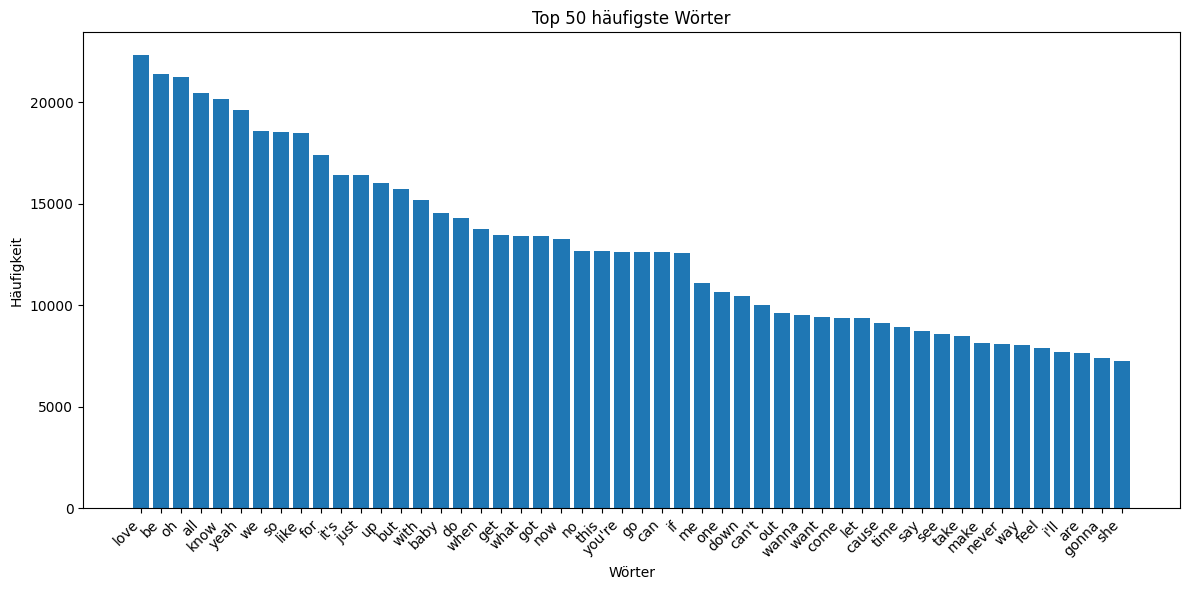

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Top N (optional)
N = 50
most_common = df3_global_no_stop.most_common(N)  # Liste von (wort, count)

# Entpacken
words, counts = zip(*most_common)  # tuples

# In Listen konvertieren, wenn du Listen brauchst
words = list(words)
counts = list(counts)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Wörter')
plt.ylabel('Häufigkeit')
plt.title(f'Top {N} häufigste Wörter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('textanalyse_top.png')
plt.show()


In [11]:
extra_stop = {'a','the','you','i','it','and','to','of','in','on', 'my', "i'm", 'your', "that", "don't", 'all', 'we', 'so', 'like', 'for', "it's", 'just', 'but', 'with', 'do', 'this', "you're", 'can', 'if', 'me', 'out'}

# 5) Optional: zusätzliche Stopwörter entfernen (z.B. 'a', 'the', 'you' falls noch vorhanden)
df3['lemmas_no_stop'] = df3['lemmas_clean'].apply(lambda toks: [t for t in toks if t not in extra_stop])
df3_global_no_stop = Counter([t for toks in df3['lemmas_no_stop'] for t in toks])
print(df3_global_no_stop.most_common(100))

[('love', 22316), ('be', 21378), ('oh', 21238), ('know', 20163), ('yeah', 19583), ('up', 15990), ('baby', 14518), ('when', 13736), ('get', 13463), ('what', 13424), ('got', 13384), ('now', 13247), ('no', 12686), ('go', 12619), ('one', 10663), ('down', 10428), ("can't", 10022), ('wanna', 9517), ('want', 9410), ('come', 9351), ('let', 9346), ('cause', 9142), ('time', 8937), ('say', 8719), ('see', 8591), ('take', 8478), ('make', 8148), ('never', 8088), ('way', 8035), ('feel', 7864), ("i'll", 7716), ('are', 7657), ('gonna', 7406), ('she', 7262), ('was', 7235), ('not', 7114), ('have', 6868), ('ooh', 6744), ('at', 6673), ('they', 6645), ('need', 6420), ('back', 6386), ('right', 6345), ('girl', 6214), ('hey', 5976), ('night', 5944), ('tell', 5928), ('how', 5691), ("i've", 5526), ('give', 5520), ('from', 5496), ('away', 5438), ('been', 5438), ('could', 5254), ('heart', 5156), ('her', 5153), ('good', 5095), ("that's", 4975), ('think', 4928), ("ain't", 4872), ('an', 4706), ('day', 4604), ('life',

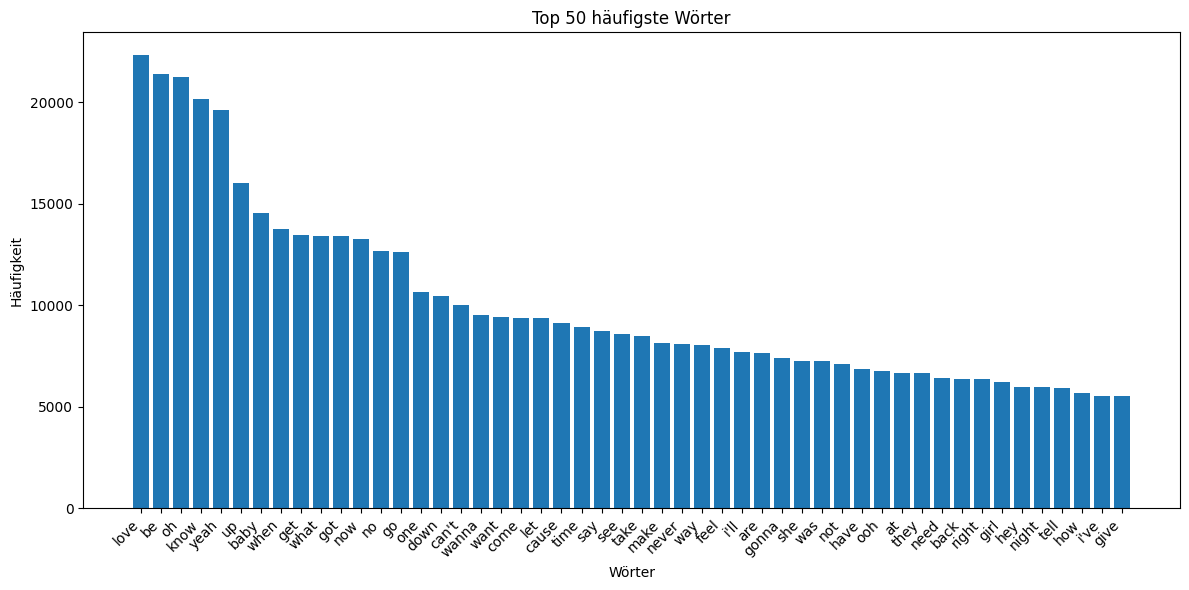

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# Top N (optional)
N = 50
df3_most_common = df3_global_no_stop.most_common(N)  # Liste von (wort, count)

# Entpacken
words, counts = zip(*df3_most_common)  # tuples

# In Listen konvertieren, wenn du Listen brauchst
words = list(words)
counts = list(counts)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Wörter')
plt.ylabel('Häufigkeit')
plt.title(f'Top {N} häufigste Wörter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('textanalyse_top.png')
plt.show()


Da mir das immer noch ein bisschen viele "kleine Wörter" sind, probiere ich mal, die NLTK-Standard-Stopword-Liste anzuwenden:

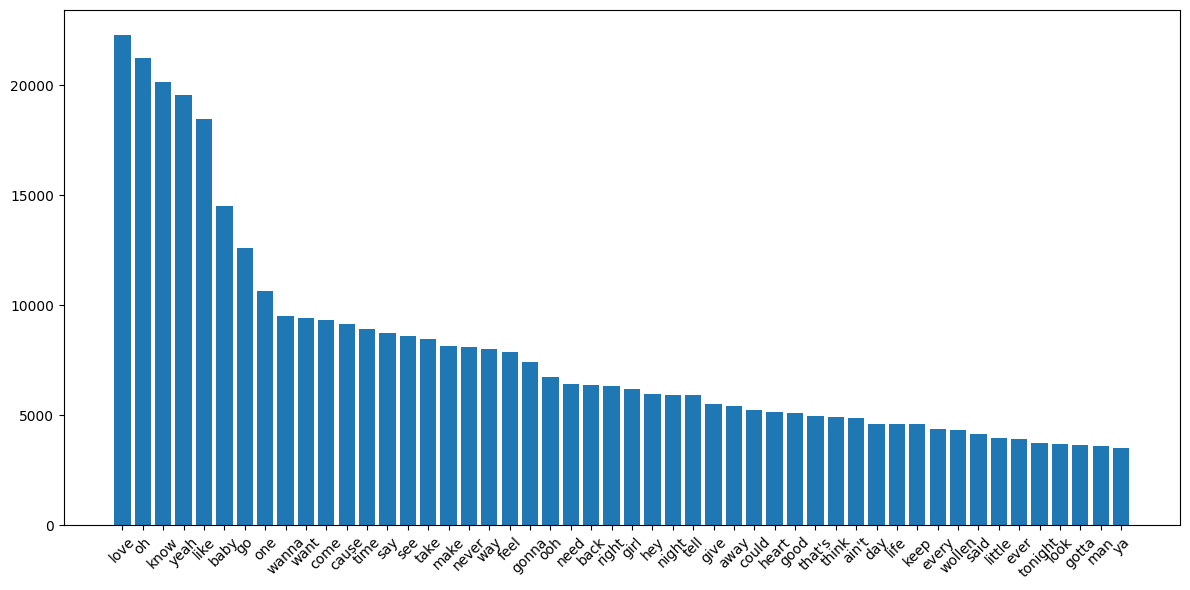

[('love', 22316), ('oh', 21238), ('know', 20163), ('yeah', 19583), ('like', 18452), ('baby', 14518), ('go', 12619), ('one', 10663), ('wanna', 9517), ('want', 9410), ('come', 9351), ('cause', 9142), ('time', 8937), ('say', 8719), ('see', 8591), ('take', 8478), ('make', 8148), ('never', 8088), ('way', 8035), ('feel', 7864), ('gonna', 7406), ('ooh', 6744), ('need', 6420), ('back', 6386), ('right', 6345), ('girl', 6214), ('hey', 5976), ('night', 5944), ('tell', 5928), ('give', 5520), ('away', 5438), ('could', 5254), ('heart', 5156), ('good', 5095), ("that's", 4975), ('think', 4928), ("ain't", 4872), ('day', 4604), ('life', 4592), ('keep', 4582), ('every', 4390), ('wollen', 4315), ('said', 4150), ('little', 3944), ('ever', 3899), ('tonight', 3744), ('look', 3707), ('gotta', 3637), ('man', 3621), ('ya', 3524), ('world', 3470), ("there's", 3445), ('mind', 3426), ('well', 3410), ('would', 3308), ('dance', 3242), ("let's", 3176), ('long', 3154), ('always', 3137), ('around', 3120), ('still', 311

In [13]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

#nltk.download('stopwords')  # einmalig
stop = set(stopwords.words('english'))  # oder 'english' etc.
custom = {'be', 'get', 'got', "can't", 'let', "i'll", 'are', "i've, 'ya'"}  # eigene Stopwörter
stop |= custom  # vereinigen (in-place)

# angenommen df3['lemmas_clean'] enthält Listen mit bereits bereinigten, lowercased Tokens
df3_all_tokens = [tok for tokens in df3['lemmas_clean'] for tok in tokens if tok not in stop]
df3_global_counter = Counter(df3_all_tokens)

words, counts = zip(*df3_global_counter.most_common(50))
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(df3_global_counter.most_common(100))


Das sieht schon besser aus. Jetzt erstelle ich eine einfache Wortwolke zum besseren Überblick.

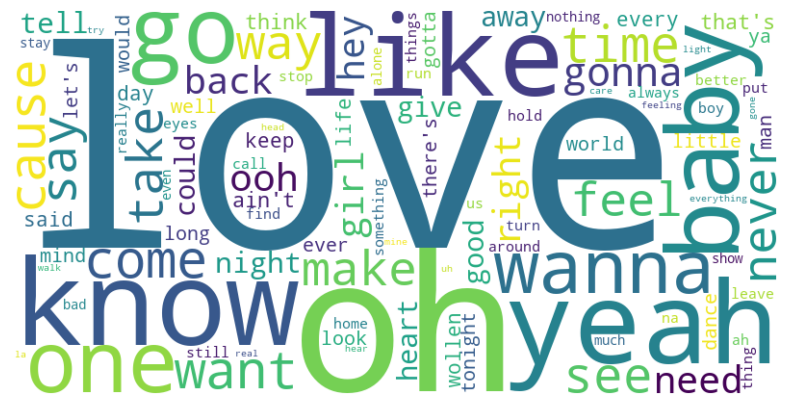

In [14]:
#Die 100 Top-Wörter als WortWolke
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# alle Tokens flach zusammenführen und Stopwörter entfernen
#all_tokens = (tok for tokens in df3['lemmas_clean'] for tok in tokens if tok not in stop)

# Häufigkeiten zählen und Top-100 auswählen
df3_top100 = dict(Counter(df3_all_tokens).most_common(100))

# Wortwolke erzeugen und anzeigen
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df3_top100)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.savefig('wordcloud_df3_100.png')  # Speichert den Plot als PNG-Datei
plt.axis('off')
plt.show()


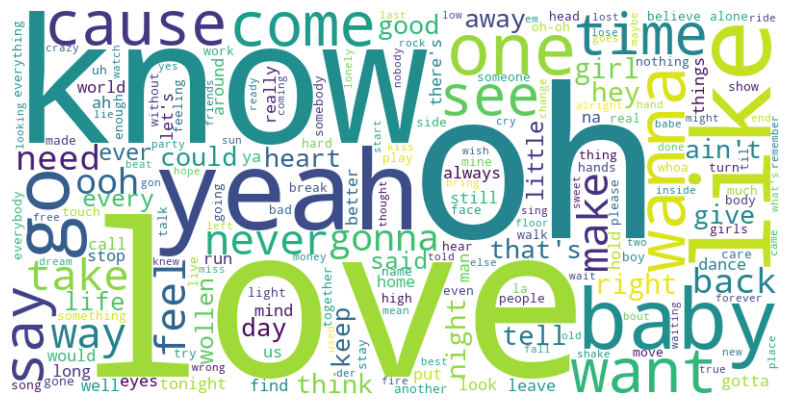

In [15]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df3_all_tokens = [tok for tokens in df3['lemmas_clean'] for tok in tokens if tok not in stop]
df3_word_counts = Counter(df3_all_tokens)

# Filtere Wörter, die mehr als 1000 Mal vorkommen
df3_filtered_word_counts = {word: count for word, count in df3_word_counts.items() if count > 1000}

# Sortiere die gefilterten Wörter nach Häufigkeit und wähle die obersten 1000 aus
df3_top_1000_word_counts = dict(sorted(df3_filtered_word_counts.items(), key=lambda item: item[1], reverse=True)[:1000])

# Erstelle die Wortwolke
df3_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df3_top_1000_word_counts)

# Visualisiere die Wortwolke
plt.figure(figsize=(10, 5))
plt.imshow(df3_wordcloud, interpolation='bilinear')
plt.axis('off')  # Achsen ausblenden
plt.savefig('wordcloud_df3_1000.png')  # Speichert den Plot als PNG-Datei
plt.show()


## DF4 - Wortwolke erstellen
Jetzt das Gleiche noch für DF4: Wörter filtern, Top-Wörter-Wolke erstellen

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

# Optional: nur einmalig ausführen, wenn Stopwords fehlen
# import nltk; nltk.download('stopwords')

CUSTOM_STOP = {'be', 'get', 'got', "can't", 'let', "i'll", 'are', "i've", 'ya'}
STOP = set(stopwords.words('english')) | CUSTOM_STOP

PUNCT = set(".,;:!?\"'()[]{}-—")

def clean_tokens(tokens):
    out = []
    for t in tokens:
        if not isinstance(t, str):
            continue
        s = t.strip()
        if not s or s in {'--', '\n', '\n '}:
            continue
        if all(ch in PUNCT for ch in s):
            continue
        out.append(s.lower())
    return out

# DataFrame-Spalte bereinigen (ändert df inplace)
df4['lemmas_clean'] = df4['lemmas'].apply(clean_tokens)

# Alle Tokens sammeln, Stopwörter entfernen, Top-Counts berechnen
df4_all_tokens = (tok for tokens in df4['lemmas_clean'] for tok in tokens)
df4_filtered = (t for t in df4_all_tokens if t not in STOP)
df4_counter = Counter(df4_filtered)

# Ausgabe: Top-100 printed, Top-50 geplottet
df4_top100 = df4_counter.most_common(100)
print(df4_top100)

words, counts = zip(*df4_counter.most_common(50))
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Annahme: 'counter' enthält bereits die Häufigkeiten (wie im vorherigen Block)
df4_top100_dict = dict(df4_counter.most_common(100))

df4_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df4_top100_dict)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.savefig('wordcloud_df4_100.png')  # Speichert den Plot als PNG-Datei
plt.axis('off')
plt.show()

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#df4_all_tokens = [tok for tokens in df4['lemmas_clean'] for tok in tokens if tok not in stop]
df4_word_counts = Counter(df4_all_tokens)

# Filtere Wörter, die mehr als 1000 Mal vorkommen
df4_filtered_word_counts = {word: count for word, count in df4_word_counts.items() if count > 1000}

# Sortiere die gefilterten Wörter nach Häufigkeit und wähle die obersten 1000 aus
df4_top_1000_word_counts = dict(sorted(df4_filtered_word_counts.items(), key=lambda item: item[1], reverse=True)[:1000])

# Erstelle die Wortwolke
df4_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df4_top_1000_word_counts)

# Visualisiere die Wortwolke
plt.figure(figsize=(10, 5))
plt.imshow(df4_wordcloud, interpolation='bilinear')
plt.axis('off')  # Achsen ausblenden
plt.savefig('wordcloud_df4_1000.png')  # Speichert den Plot als PNG-Datei
plt.show()


In [ ]:
# #Die 100 Top-Wörter als WortWolke
# import matplotlib.pyplot as plt
# from collections import Counter
# from wordcloud import WordCloud

# # alle Tokens flach zusammenführen und Stopwörter entfernen
# #all_tokens = (tok for tokens in df4['lemmas_clean'] for tok in tokens if tok not in stop)

# # Häufigkeiten zählen und Top-100 auswählen
# top100 = dict(Counter(all_tokens).most_common(100))

# # Wortwolke erzeugen und anzeigen
# wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top100)
# plt.figure(figsize=(10, 5))
# plt.imshow(wc, interpolation='bilinear')
# plt.axis('off')
# plt.show()


In [ ]:
# print("Wörter, die mehr als 500 Mal vorkommen:")
# # Filtere die Wörter, die mehr als 500 Mal vorkommen
# filtered_words = {word: count for word, count in filtered_word_counts.items() if count > 500}

# # Sortiere die gefilterten Wörter nach der Anzahl (count) in absteigender Reihenfolge
# sorted_word_counts = sorted(filtered_words.items(), key=lambda item: item[1], reverse=True)

# # Erstelle eine formatierte Ausgabe
# output = " | ".join([f"{word}: {count}" for word, count in sorted_word_counts])
# print(output)


## Themen-Analyse

Als nächstes probieren wir eine Themen-Analyse mit einer Latent Dirichlet Allocation (LDA) und Non-negative Matrix Factorization (NMF), 

Die LDA sieht sich die Verteilung der Wörter an und versucht daraus Rückschlüsse über die Themen zu finden, indem es sich die Songs als einzelne "Dokumente" ansieht und nach gemeinsam vorkommenden Wörtern sucht. 
Es wird angenommen, dass Themen Gruppen von Wörtern sind, die häufig zusammen vorkommen. Und, dass jedes Dokument eine Mischung von Themen enthält. 

Als erstes legt die LDA eine Menge von Themen fest z.B. fünf Themen. Dann legt es zufällig eine Mischung der Themen fest, z.B. 20% Thema 1, 40% Thema 2 usw. und sammelt Wörter zu den Themen. 
Es werden Gruppen von oft zusammen vorkommenen Wörtern gefunden, diese werden dann als gemeinsame Themen erkannt. 
Dieser Prozess wird immer wieder wiederholt, bis die Verteilung immer genauer wird.

Die NMF zerlegt eine TF-IDF in zwei Matrizen und untersuche Häufigkeit und Gewichtung von Themen im Dokument. 

In [30]:
#!pip install gensim nltk
#!pip install pyLDAvis

#!pip install scikit-learn

In [31]:
import gensim
from gensim import corpora
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Erstelle eine Liste von Listen von Wörtern
texts = [lyrics.split() for lyrics in df3['processed_lyrics']]

# Erstelle ein Wörterbuch und ein Korpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

corpora.Dictionary(texts) erstellt ein Wörterbuch, das jedem einzigartigen Wort in den Texten eine eindeutige ID zuweist.

dictionary.doc2bow(text) konvertiert jeden Text in eine Bag-of-Words-Darstellung, die eine Liste von (Wort-ID, Häufigkeit)-Tupeln ist. Dies ist die Form, die LDA benötigt.

Jetzt führen wir die Analyse durch, dabei lege ich fest, dass 3 Themen erkannt werden sollen und 15 Durchläufe zum Lernen benutzt werden.

In [32]:
# from gensim.models import LdaModel

# # Anzahl der Themen
# num_topics = 3

# # LDA-Modell erstellen
# lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# # Themen anzeigen
# for idx, topic in lda_model.print_topics(-1):
#     print(f'Thema {idx + 1}: {topic}')

Wir sehen, Thema 1 ist eher aktiv mit "love, good, get, want, girl, dance, feel", Thema 2 ist eher der Liebe gewidmet: "love, want, feel, get, time, way, night, heart" und Thema 3: "get, want, baby, girl" ist auch eher der Liebe gewidmet.
Beim nächsten Versuch probieren wir es mit 5 Themen und 20 Durchläufen

In [33]:
# from gensim.models import LdaModel

# # Anzahl der Themen
# num_topics = 5

# # LDA-Modell erstellen
# lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)

# # Themen anzeigen
# for idx, topic in lda_model.print_topics(-1):
#     print(f'Thema {idx + 1}: {topic}')


Thema 1 ist eher aktiv, positiv mit "run, good, play, want"
<br>Thema 2 ist positiv mit Liebe verbunden: "get, baby, want, dance, girl, let, come, love, to, feel"
<br>Thema 3 ist eher ruhiger und mit Liebe verbunden: "love, want, feel, time, heart"
<br>Thema 5 ist eher mit körperlichen Dingen verbunden

Und nun noch 10 Themen und 30 Durchläufe:

In [34]:
from gensim.models import LdaModel

# Anzahl der Themen
num_topics = 10

# LDA-Modell erstellen
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30)

# Themen anzeigen
for idx, topic in lda_model.print_topics(-1):
    print(f'Thema {idx + 1}: {topic}')


Thema 1: 0.028*"time" + 0.018*"feel" + 0.017*"day" + 0.015*"life" + 0.015*"ah" + 0.013*"tell" + 0.012*"world" + 0.011*"find" + 0.011*"go" + 0.011*"lose"
Thema 2: 0.029*"boom" + 0.023*"jump" + 0.019*"Na" + 0.013*"bass" + 0.012*"Mr." + 0.011*"bam" + 0.010*"que" + 0.010*"Boom" + 0.008*"de" + 0.008*"hell"
Thema 3: 0.032*"man" + 0.024*"boy" + 0.014*"woman" + 0.014*"'bout" + 0.012*"get" + 0.011*"eh" + 0.011*"go" + 0.010*"girl" + 0.010*"round" + 0.009*"young"
Thema 4: 0.034*"think" + 0.024*"get" + 0.023*"right" + 0.022*"way" + 0.019*"love" + 0.019*"well" + 0.019*"heart" + 0.014*"go" + 0.014*"somebody" + 0.013*"break"
Thema 5: 0.050*"uh" + 0.031*"ba" + 0.030*"low" + 0.019*"da" + 0.017*"huh" + 0.014*"bitch" + 0.012*"fuck" + 0.010*"nigga" + 0.010*"shit" + 0.010*"baby"
Thema 6: 0.144*"love" + 0.032*"baby" + 0.025*"night" + 0.023*"feel" + 0.019*"need" + 0.017*"want" + 0.015*"heart" + 0.014*"get" + 0.013*"gonno" + 0.012*"come"
Thema 7: 0.023*"run" + 0.022*"away" + 0.017*"gonno" + 0.014*"home" + 0.0

Hier sieht man, dass sich die Themen etwas mehr ausdifferenzieren

Hier muss man ein wenig experimentieren, bis sich sinnvolle Themengruppen herauskriistallisieren.
In diesem Fall steigt die Relevanz der Wörter mit der Menge der Themen. Außerdem werden sie unterschiedlicher, es dreht sich nicht nur um Liebe, sondern die Themen werden etwas diversifizierter.

Das Ganze kann man auch grafisch darstellen - bei der Visualisierung handelt es sich um eine Art Clusterdiagramm, wobei die Themen nach Ähnlichkeit der Wortgruppen angeordnet sind. Wenn sie näher zusammenstehen, ähneln sie sich mehr, als wenn sie weiter auseinander stehen. 
Die Kreisgröße stellt die relative Häufigkeit des Themas im gesamten Korpus, also der Liste der Wörter dar. Ein großer Kreis repräsentiert also ein häufiger vorkommendes Thema als ein kleiner Kreis.
Der Lambda-Slider stellt das Verhältnis von Vorkommen in allen Dokumenten zu Vorkommen in dem einzelnen Dokument ein - ein hoher Wert betont die weniger vorkommenen Worte, die aber vielleicht mehr Relevanz haben. Ein niedriger Wert betont die Worte, die besonders häufig vorkommen.

In [35]:
import pyLDAvis
import pyLDAvis.gensim_models

# Visualisierung der Themen
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


Jetzt probieren wir noch mal eine andere Art der LDA Analyse, LDA (Latent Dirichlet Allocation) mit sklearn und eine NMF - Non negative Matrix Factorization. 
Wobei die LDA ähnlich funktioniert wie oben, allerdings nicht auf Text spezialisiert ist. Sie ist für viele unterschiedliche Wörter pro Dokument geeignet. 

Die NMF-Analyse sucht einfach nach statistischen Häufungen in den Dokumenten anhand der TDF-IDF Vektorisierung (Term Frequency-Inverse Document Frequency). Dabei wird eine Gewichtung von Wörtern in den Dokumenten (Songtexten) vorgenommen, häufige Wörter werden weniger gewichtet, um Füllwörter auszuschließen. Wörter, die nur in wenigen Dokumenten (Songs) vorkommen, werden ebenfalls ausgeschlossen.

In [36]:
# import pandas as pd
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer

# # Erstelle ein CountVectorizer-Objekt
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(df3['processed_lyrics'])

# # LDA-Modell erstellen
# lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
# lda_model.fit(X)

# # Themen anzeigen
# for index, topic in enumerate(lda_model.components_):
#     print(f'Thema {index}:')
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

In [5]:
import pandas as pd

df4 = pd.read_csv('unique_df2_with_lang.csv')
df4.info()
df4["language"].value_counts().head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794360 entries, 0 to 794359
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                794360 non-null  object 
 1   name              794351 non-null  object 
 2   album_name        307373 non-null  object 
 3   artists           794360 non-null  object 
 4   danceability      794360 non-null  float64
 5   energy            794360 non-null  float64
 6   key               794360 non-null  object 
 7   loudness          794360 non-null  float64
 8   mode              794360 non-null  object 
 9   speechiness       794360 non-null  float64
 10  acousticness      794360 non-null  float64
 11  instrumentalness  794360 non-null  float64
 12  liveness          794360 non-null  float64
 13  valence           794360 non-null  float64
 14  tempo             794360 non-null  float64
 15  duration_ms       794360 non-null  float64
 16  lyrics            79

language
en         571319
es          68869
pt          33890
Unknown     16705
fr          16672
de          14145
ja          13815
zh          10724
ko           9437
ru           4763
sv           4748
hi           4407
it           3621
tr           2261
tl           2085
fi           1836
ta           1606
id           1212
nl           1189
ar           1014
pl            949
fa            910
he            778
da            734
pa            568
te            468
ml            418
el            403
eu            385
bn            341
no            294
cs            284
vi            271
hu            271
ur            258
is            224
ca            213
uk            202
kn            170
th            166
ku            163
mr            152
sr            117
am            110
ro             99
ne             75
ga             74
or             69
et             51
lv             47
Name: count, dtype: int64

In [6]:
df4 = df4[df4["language"] == "en"]
#df3 = df3[df3["language"] == "en"]
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571319 entries, 0 to 794357
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                571319 non-null  object 
 1   name              571313 non-null  object 
 2   album_name        228137 non-null  object 
 3   artists           571319 non-null  object 
 4   danceability      571319 non-null  float64
 5   energy            571319 non-null  float64
 6   key               571319 non-null  object 
 7   loudness          571319 non-null  float64
 8   mode              571319 non-null  object 
 9   speechiness       571319 non-null  float64
 10  acousticness      571319 non-null  float64
 11  instrumentalness  571319 non-null  float64
 12  liveness          571319 non-null  float64
 13  valence           571319 non-null  float64
 14  tempo             571319 non-null  float64
 15  duration_ms       571319 non-null  float64
 16  lyrics            571319 

#TEST

In [25]:
import os
import pandas as pd
import spacy
from tqdm.auto import tqdm
import time

# Einstellungen
OUTPUT_CSV = "songs_processed.csv"
LYRICS_COL = "lyrics"
ID_COL = "id"
TEXT_COL = "processed_lyrics"
SPACY_BATCH = 256
#N_PROCESS = os.cpu_count()
N_PROCESS = 8  # Windows

# Aus deiner Messung
avg_bytes_with_overhead = 1424.757
target_bytes = 500 * 1024 * 1024
computed_chunk = int(target_bytes // avg_bytes_with_overhead)
# clamp
CHUNK_SIZE = max(100, min(computed_chunk, 1000))

print(f"Computed chunk_size={computed_chunk}, using CHUNK_SIZE={CHUNK_SIZE}")

# Lade spaCy (ner deaktiviert für Speed)
nlp = spacy.load("en_core_web_md")

def process_df_in_chunks(df, output_csv=OUTPUT_CSV, chunk_size=CHUNK_SIZE):
    if os.path.exists(output_csv):
        os.remove(output_csv)
    mode = "w"
    header_written = False

    total = len(df)
    pbar = tqdm(unit="rows", total=total, desc="Processing", mininterval=1.0)
    start_time = time()
    
    for start in range(0, total, chunk_size):
        chunk = df.iloc[start:start+chunk_size].copy()
        print(f"Verarbeite Chunk {start//chunk_size + 1}: {len(chunk)} Zeilen")
        if ID_COL not in chunk.columns:
            chunk[ID_COL] = chunk.index.astype(str)
        if LYRICS_COL not in chunk.columns:
            chunk[LYRICS_COL] = ""

        texts = chunk[LYRICS_COL].fillna("").astype(str).tolist()
        processed = []
        for doc in nlp.pipe(texts, batch_size=SPACY_BATCH, n_process=N_PROCESS):
            tokens = [tok.lemma_ for tok in doc if not tok.is_stop and not tok.is_punct and tok.is_alpha]
            processed.append(" ".join(tokens))
        chunk[TEXT_COL] = processed

        cols_to_save = [c for c in [ID_COL, "Track Name", LYRICS_COL, TEXT_COL] if c in chunk.columns]
        chunk[cols_to_save].to_csv(output_csv, mode=mode, header=not header_written, index=False, encoding="utf-8")
        mode = "a"
        header_written = True
        print(f"Chunk verarbeitet in {time() - start_time:.2f} Sekunden")
        pbar.update(len(chunk))

    pbar.close()
    print("Done — output:", output_csv)

#process_df_in_chunks(df4)

# Verwendung im Notebook
# Angenommen, df4 ist Ihr DataFrame
#process_dataframe_in_chunks(df4, chunk_size=10000)

test_df = df4.sample(10000)  # Zufällige 1000 Zeilen
print(f"Testset Größe: {len(test_df)} Zeilen")
print(f"Spalten: {test_df.columns}")

# Überprüfe Liedtexte
print("\nBeispiel-Liedtexte:")
print(test_df[LYRICS_COL].head())

# Verarbeitung starten
#process_dataframe_in_chunks(test_df, chunk_size=10000, output_csv="test_processed_lyrics.csv")


Computed chunk_size=367984, using CHUNK_SIZE=1000
Testset Größe: 10000 Zeilen
Spalten: Index(['id', 'name', 'album_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'lyrics', 'language'],
      dtype='object')

Beispiel-Liedtexte:
643547    One by one, ticking time bombs won\n It's not ...
698215    Sometimes I can be my own worst enemy\n A lot ...
474417    Old people are pushy\n They don't have much ti...
278468    I come from the jungle\n From Popocatepetl\n C...
580386    Zoo Wop\n Gang shit members only, man\n You kn...
Name: lyrics, dtype: object


Verarbeitung:   0%|          | 0/10000 [00:00<?, ?Zeilen/s]

KeyboardInterrupt: 

In [26]:
import os
import pandas as pd
import spacy
from tqdm.notebook import tqdm
import time

# Konfiguration
OUTPUT_CSV = "processed_lyrics.csv"
LYRICS_COL = "lyrics"
ID_COL = "id"
TEXT_COL = "processed_lyrics"

# spaCy-Modell laden
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def process_lyrics_chunk(texts):
    """Verarbeitet einen Chunk von Texten"""
    processed_texts = []
    for text in texts:
        if not isinstance(text, str):
            processed_texts.append("")
            continue
        
        doc = nlp(text.lower())
        processed = " ".join([
            tok.lemma_ for tok in doc 
            if tok.is_alpha  # Nur alphabetische Tokens
            and len(tok.lemma_) > 1  # Mindestlänge
        ])
        processed_texts.append(processed)
    
    return processed_texts

def process_dataframe_in_chunks(df, output_csv=OUTPUT_CSV, chunk_size=1000):
    """Verarbeitet DataFrame in Chunks mit Fortschrittsanzeige"""
    
    # Startzeit und Gesamtfortschritt
    start_total_time = time.time()
    total_rows = len(df)
    
    # Fortschrittsanzeige
    with tqdm(total=total_rows, desc="Verarbeitung", unit="Zeilen") as pbar:
        # Chunks verarbeiten
        for start in range(0, total_rows, chunk_size):
            chunk_start_time = time.time()
            
            # Chunk extrahieren
            chunk = df.iloc[start:start+chunk_size].copy()
            
            # Texte verarbeiten
            chunk[TEXT_COL] = process_lyrics_chunk(
                chunk[LYRICS_COL].fillna("").tolist()
            )
            
            # Nur relevante Spalten speichern
            cols_to_save = [ID_COL, LYRICS_COL, TEXT_COL]
            cols_to_save = [col for col in cols_to_save if col in chunk.columns]
            
            # In CSV speichern (append-Modus)
            chunk_mode = 'w' if start == 0 else 'a'
            chunk_header = start == 0
            
            chunk[cols_to_save].to_csv(
                output_csv, 
                mode=chunk_mode, 
                header=chunk_header, 
                index=False,
                encoding='utf-8'
            )
            
            # Chunk-Statistiken
            chunk_time = time.time() - chunk_start_time
            estimated_remaining = (total_rows - start) / chunk_size * chunk_time
            
            # Fortschrittsanzeige aktualisieren
            pbar.update(len(chunk))
            pbar.set_postfix({
                'Chunk-Zeit': f'{chunk_time:.2f}s', 
                'Geschätzte Restzeit': f'{estimated_remaining:.2f}s'
            })
    
    # Gesamtzeit
    total_time = time.time() - start_total_time
    print(f"\nGesamtverarbeitungszeit: {total_time:.2f} Sekunden")
    print(f"Verarbeitete Texte gespeichert in: {output_csv}")

# Verwendung im Notebook
# Angenommen, df4 ist Ihr DataFrame
process_dataframe_in_chunks(df4, chunk_size=10000)

# test_df = df4.sample(10000)  # Zufällige 1000 Zeilen
# print(f"Testset Größe: {len(test_df)} Zeilen")
# print(f"Spalten: {test_df.columns}")

# # Überprüfe Liedtexte
# print("\nBeispiel-Liedtexte:")
# print(test_df[LYRICS_COL].head())

# # Verarbeitung starten
# process_dataframe_in_chunks(test_df, chunk_size=1000, output_csv="test_processed_lyrics.csv")


Verarbeitung:   0%|          | 0/571319 [00:00<?, ?Zeilen/s]


Gesamtverarbeitungszeit: 12146.03 Sekunden
Verarbeitete Texte gespeichert in: processed_lyrics.csv


In [20]:
processed_df.info()

,id,lyrics,processed_lyrics
0,6E79gbaYFEjBkQDdxqyIqC,Why don't you play that F sharp?\n ♪\n We didn...,why do you play that sharp we do come around h...
1,6VvtB3qtTyExMsz22ZwelR,You remember when our lives were all so simple...,you remember when our life be all so simple we...
2,4gwF1NiLbZl2uKJDS3AX9O,"My beats steady knockin', uh-huh\n My beats st...",my beat steady knockin uh huh my beat steady k...
3,3VfemdfydzRq2amWXMMX33,As if I had a choice to change the course\n Yo...,as if have choice to change the course you thi...
4,48AEz2kYFwWBNH0TR7lMib,No way out of your misery\n Alone in pain and ...,no way out of your misery alone in pain and ag...


#TEST

In [25]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571319 entries, 0 to 794357
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                571319 non-null  object 
 1   name              571313 non-null  object 
 2   album_name        228137 non-null  object 
 3   artists           571319 non-null  object 
 4   danceability      571319 non-null  float64
 5   energy            571319 non-null  float64
 6   key               571319 non-null  object 
 7   loudness          571319 non-null  float64
 8   mode              571319 non-null  object 
 9   speechiness       571319 non-null  float64
 10  acousticness      571319 non-null  float64
 11  instrumentalness  571319 non-null  float64
 12  liveness          571319 non-null  float64
 13  valence           571319 non-null  float64
 14  tempo             571319 non-null  float64
 15  duration_ms       571319 non-null  float64
 16  lyrics            571319 

Da in der gemeinsamen Datei beinahe nur englischsprachige Songs vorkamen, beschränke ich mich darauf, auch nur diese in df4 zu analysieren. Immerhin sind es hier immer noch knapp 100 mal mehr Songs als Vergleichsmaterial, aber knapp 200.000 Songs fallen dabei raus. Es wäre durchaus eine Überlegung, auch diese Songs entweder zu übersetzen (wobei sprachliche Feinheiten verloren gehen, das wäre aber OK für thematische Analyse) oder eigene Analysen für die häufiger vorkommenen Sprachen zu machen. Dies wäre eine gute Idee für eine tiefergehende Analyse, werde ich aber aus Zeitgründen hier nicht umsetzen.

In dieser Analyse differenzieren sich die Themen schon etwas schneller: Hier Thema 0: Liebe, Thema 1: etwas allgemeiner, aber auch liebeslastig und Thema 3: eher aktiv mit viel "uh" und "ah"

In [37]:
# import pandas as pd
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer

# # Erstelle ein CountVectorizer-Objekt
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(df3['processed_lyrics'])

# # LDA-Modell erstellen
# lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
# lda_model.fit(X)

# # Themen anzeigen
# for index, topic in enumerate(lda_model.components_):
#     print(f'Thema {index}:')
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Hier sind sich die Themen relativ ähnlich,

In [38]:
# <!-- import pandas as pd
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer

# # Erstelle ein CountVectorizer-Objekt
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(df3['processed_lyrics'])

# # LDA-Modell erstellen
# lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
# lda_model.fit(X)

# # Themen anzeigen
# for index, topic in enumerate(lda_model.components_):
#     print(f'Thema {index}:')
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]) -->

Sehr schön thematisch passend ist Thema 5: 'party', 'boom', 'ride', 'come', 'want', 'get', 'let', 'tonight', 'good', 'dance'

Man sieht wieder, dass die Themen sich stärker ausdifferenzieren, je mehr es gibt.

Leider konnte ich keine Visualisierung für diese Werte erstellen.


### NMF Analyse

Arbeiten wir hier noch mit der NMF-Analyse. Der min_df Wert, also in wie vielen Songs ein Wort mindestens vorkommen sollte, spielt eine Rolle, er soll zwischen 1 und 5% liegen. Wir setzen ihn hier mal auf 2,5%, also etwa 150 Songs. 
Weiterhin interessant ist der Wert max_df. Die Wörter, die in mehr als 95% der Songs vorkommen werden ebenfalls ignoriert, da es ja um eine Verteilung der Wörter und Themen geht. Wenn ein Wort in jedem Song vorkommt, ist es für diese Betrachtung uninteressant.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer(max_df=0.95, min_df=150, stop_words='english')
tfidf = vectorizer.fit_transform(df3['processed_lyrics'])

# NMF-Modell erstellen
nmf_model = NMF(n_components=3, random_state=1)
nmf_model.fit(tfidf)

# Themen anzeigen
for index, topic in enumerate(nmf_model.components_):
    print(f'Thema {index}:')
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))


Thema 0:
good think away life way night day gonno feel time
Thema 1:
tell forever believe touch true feel fall need heart love
Thema 2:
right cause ooh uh tell ya need girl baby want


\\?\C:\Users\jakob\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
\\?\C:\Users\jakob\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
\\?\C:\Users\jakob\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


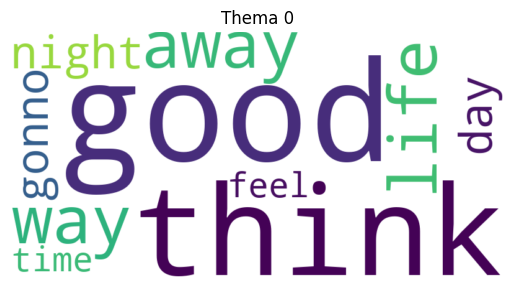

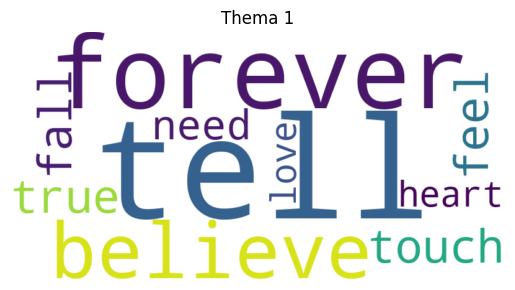

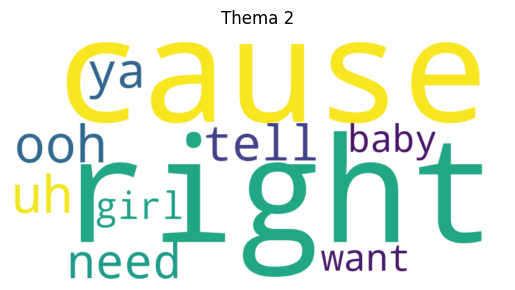

In [40]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Clouds für jedes Thema erstellen
for index, topic in enumerate(nmf_model.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Thema {index}')
    plt.savefig('Wordcloud_nmf_1')
    plt.show()


![Mein Plot](D:/_code/0_DA/Abschlussprojekt/data/wordcloud_nmf_1.png)

Hier ist es ein bisschen anders, Thema 0: positiv, alltägliches, Thema 2: Liebe, Thema 3: schmachtende Liebe

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer(max_df=0.95, min_df=150, stop_words='english')
tfidf = vectorizer.fit_transform(df3['processed_lyrics'])

# NMF-Modell erstellen
nmf_model = NMF(n_components=5, random_state=1)
nmf_model.fit(tfidf)

# Themen anzeigen
for index, topic in enumerate(nmf_model.components_):
    print(f'Thema {index}:')
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))


Thema 0:
good way think life away night day gonno feel time
Thema 1:
tell believe forever feel touch fall true need heart love
Thema 2:
need right little good girl ya let come ooh baby
Thema 3:
body uh ya cause feel somebody tell need girl want
Thema 4:
everybody man huh whoa dance ya uh girl ah hey


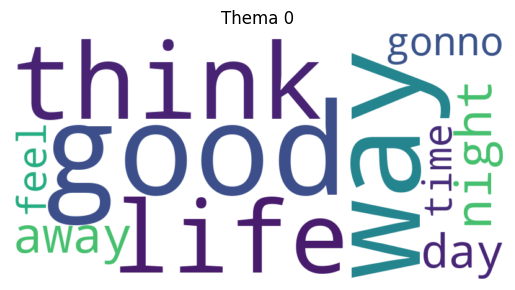

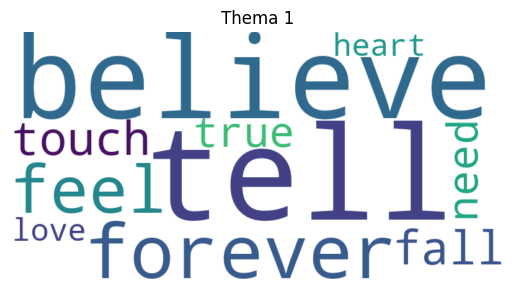

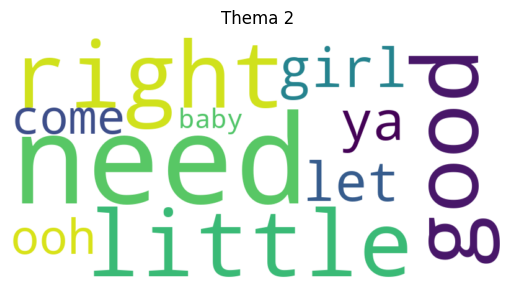

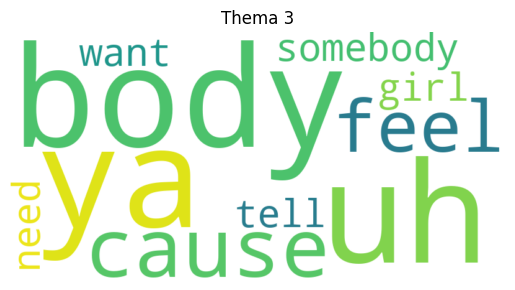

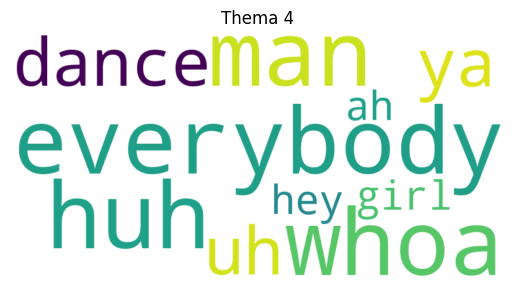

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Clouds für jedes Thema erstellen
for index, topic in enumerate(nmf_model.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Thema {index}')
    plt.savefig('Wordcloud_nmf_2')
    plt.show()


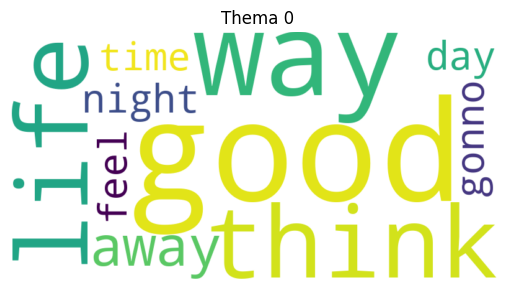

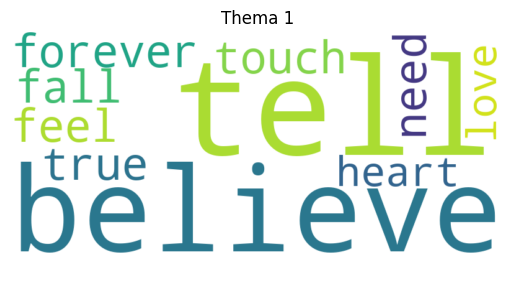

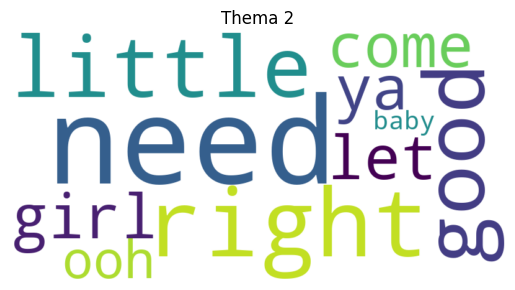

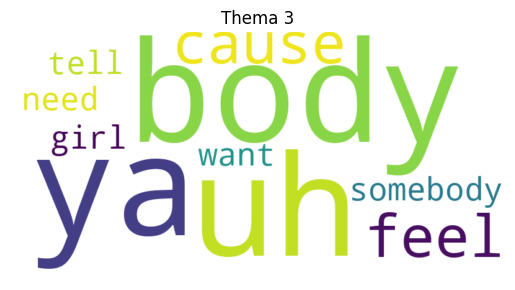

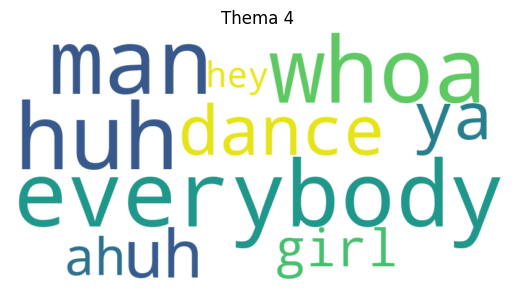

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Clouds für jedes Thema erstellen
for index, topic in enumerate(nmf_model.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Thema {index}')
    plt.savefig('Wordcloud_nmf_2')
    plt.show()


Hier fällt auf, dass Thema 0 sehr nah an dem Thema 0 von vorher dran ist. Thema 4 ist sehr körperlich

In [44]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import NMF

# # TF-IDF-Vektorisierung
# vectorizer = TfidfVectorizer(max_df=0.95, min_df=20, stop_words='english')
# tfidf = vectorizer.fit_transform(df3['processed_lyrics'])

# # NMF-Modell erstellen
# nmf_model = NMF(n_components=10, random_state=1)
# nmf_model.fit(tfidf)

# # Themen anzeigen
# for index, topic in enumerate(nmf_model.components_):
#     print(f'Thema {index}:')
#     print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))


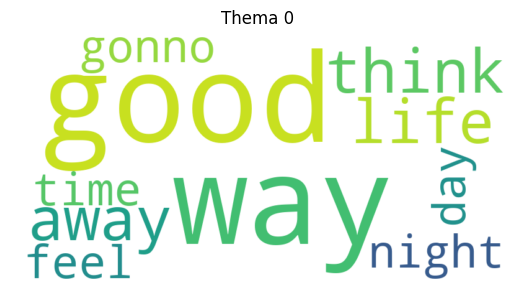

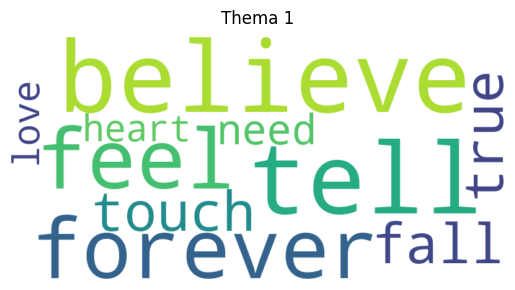

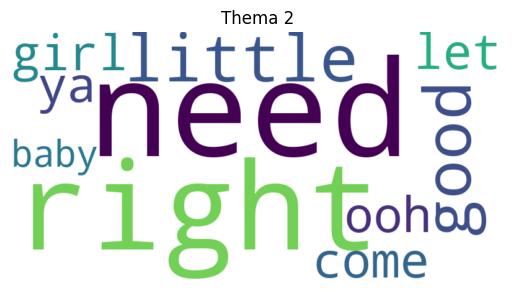

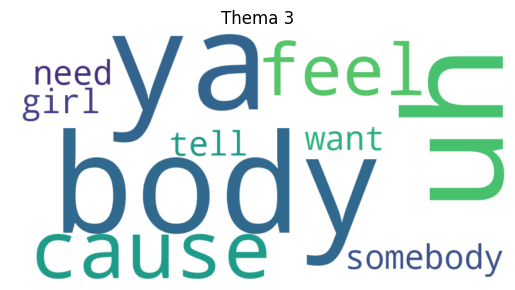

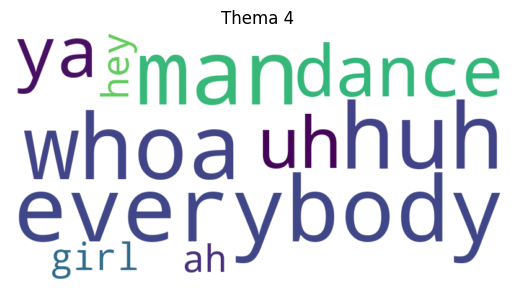

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Clouds für jedes Thema erstellen
for index, topic in enumerate(nmf_model.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Thema {index}')
    plt.savefig('Wordcloud_nmf_3.png')
    plt.show()


![Mein Plot](D:/_code/0_DA/Abschlussprojekt/data/Wordcloud_nmf_3.png)

Auch hier ist Thema 0 sehr ähnlich wie bei den vorherigen Analysen, wahrscheinlich sind es die häufigsten Wörter. 
Dann kommt viel Liebe, aner in Themen 4 und 5 fällt auf, dass ein Wörter wie murder und dark eingestreut sind
Thema 6 ist ein Füllwort-Thema
In Thema 7 geht es vielleicht um Beschreibungen von Äußerlichkeiten
Thema 8 kümmert sich um Bewegung
Thema 9 um Party

Die Ergebnisse dieser Analyse sind noch mal anders und in sich etwas stabiler, dafür anfälliger für kleine Wörter.

Wenn wir die Themen miteinander vergleichen, fällt auf, dass...

## N-Gramme

Schauen wir uns noch die N-Gramme an, also Verbindungen von n-Worten, die miteinander zusammenhängen.

In [46]:
import warnings

# Ignoriere FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Häufigste 2-Gramme: [(('love', 'love'), 3496), (('get', 'to'), 2811), (('ah', 'ah'), 2378), (('hey', 'hey'), 1953), (('want', 'want'), 1913), (('da', 'da'), 1626), (('doo', 'doo'), 1245), (('baby', 'baby'), 1003), (('uh', 'uh'), 981), (('whoa', 'whoa'), 965), (('low', 'low'), 830), (('uh', 'huh'), 789), (('shake', 'shake'), 771), (('ha', 'ha'), 769), (('way', 'way'), 717), (('feel', 'good'), 710), (('want', 'love'), 701), (('good', 'good'), 695), (('little', 'bit'), 663), (('run', 'away'), 643), (('get', 'get'), 629), (('time', 'time'), 586), (('eh', 'eh'), 585), (('run', 'run'), 584), (('dance', 'dance'), 583), (('love', 'want'), 559), (('fall', 'love'), 548), (('ya', 'ya'), 544), (('feel', 'feel'), 536), (('love', 'baby'), 521), (('need', 'need'), 515), (('break', 'heart'), 512), (('Got', 'to'), 509), (('noh', 'noh'), 506), (('walk', 'walk'), 499), (('be', 'get'), 497), (('work', 'work'), 474), (('lie', 'lie'), 468), (('good', 'time'), 466), (('love', 'feel'), 462), (('ba', 'ba'), 45

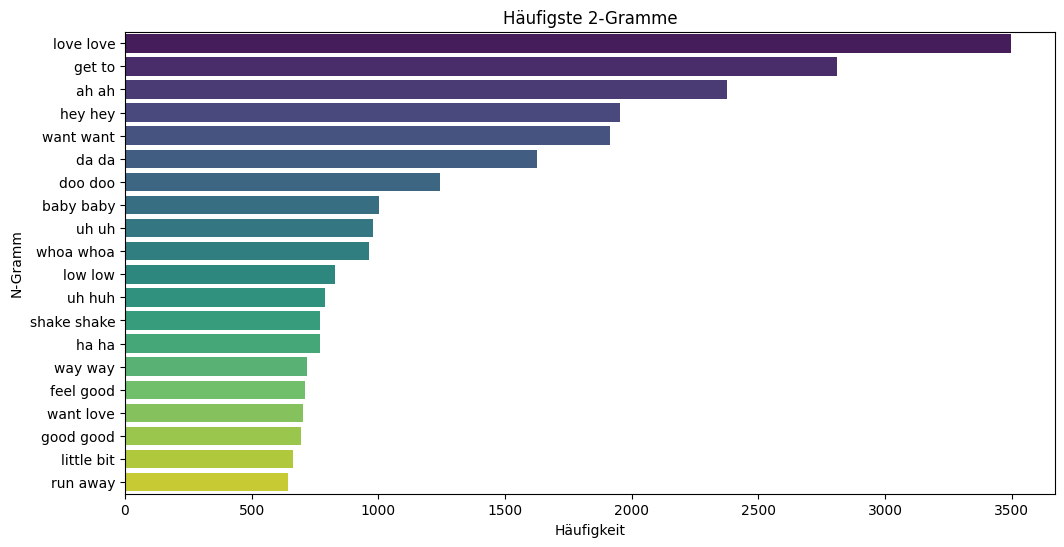

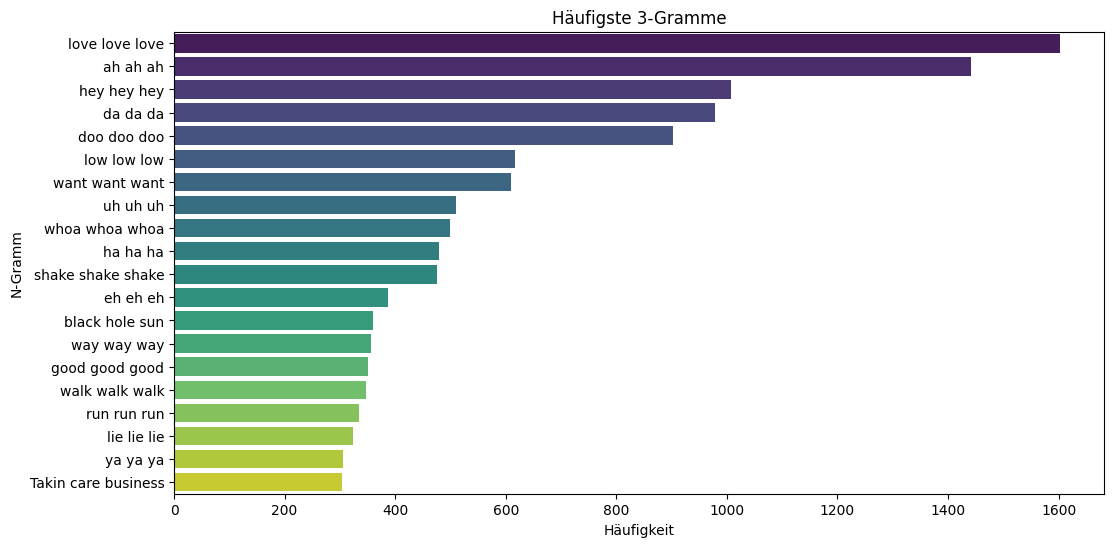

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams  # Importiere die ngrams-Funktion

def get_ngrams(text_series, n):
    all_ngrams = []
    for text in text_series:
        tokens = text.split()
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(100)  # Die 100 häufigsten N-Gramme

# Beispiel für 2-Gramme
top_bigrams = get_ngrams(df3['processed_lyrics'], 2)
print("Häufigste 2-Gramme:", top_bigrams)

# Beispiel für 3-Gramme
top_trigrams = get_ngrams(df3['processed_lyrics'], 3)
print("Häufigste 3-Gramme:", top_trigrams)

# Funktion zur Visualisierung der N-Gramme
def plot_ngrams(ngrams_list, title):
    ngrams_df = pd.DataFrame(ngrams_list, columns=['N-Gram', 'Frequency'])
    ngrams_df['N-Gram'] = ngrams_df['N-Gram'].apply(lambda x: ' '.join(x))  # N-Gramme in Strings umwandeln

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='N-Gram', data=ngrams_df.head(20), palette='viridis')
    plt.title(title)
    plt.xlabel('Häufigkeit')
    plt.ylabel('N-Gramm')
    plt.show()

# Visualisierung der häufigsten 2-Gramme
plot_ngrams(top_bigrams, 'Häufigste 2-Gramme')
print()
# Visualisierung der häufigsten 3-Gramme
plot_ngrams(top_trigrams, 'Häufigste 3-Gramme')


Häufigste 2-Gramme: 

[(('love', 'love'), 3496), (('get', 'to'), 2811), (('ah', 'ah'), 2378), (('hey', 'hey'), 1953), (('want', 'want'), 1913), (('da', 'da'), 1626), (('doo', 'doo'), 1245), (('baby', 'baby'), 1003), (('uh', 'uh'), 981), (('whoa', 'whoa'), 965), (('low', 'low'), 830), (('uh', 'huh'), 789), (('shake', 'shake'), 771), (('ha', 'ha'), 769), (('way', 'way'), 717), (('feel', 'good'), 710), (('want', 'love'), 701), (('good', 'good'), 695), (('little', 'bit'), 663), (('run', 'away'), 643), (('get', 'get'), 629), (('time', 'time'), 586), (('eh', 'eh'), 585), (('run', 'run'), 584), (('dance', 'dance'), 583), (('love', 'want'), 559), (('fall', 'love'), 548), (('ya', 'ya'), 544), (('feel', 'feel'), 536), (('love', 'baby'), 521), (('need', 'need'), 515), (('break', 'heart'), 512), (('Got', 'to'), 509), (('noh', 'noh'), 506), (('walk', 'walk'), 499), (('be', 'get'), 497), (('work', 'work'), 474), (('lie', 'lie'), 468), (('good', 'time'), 466), (('love', 'feel'), 462), (('ba', 'ba'), 456), (('care', 'business'), 448), (('night', 'night'), 439), (('need', 'love'), 439), (('come', 'come'), 439), (('baby', 'want'), 430), (('baby', 'love'), 425), (('close', 'eye'), 418), (('right', 'right'), 413), (('girl', 'girl'), 407), (('go', 'go'), 403), (('night', 'long'), 396), (('jump', 'jump'), 396), (('tell', 'tell'), 390), (('boom', 'boom'), 389), (('black', 'hole'), 385), (('girl', 'want'), 382), (('ay', 'ay'), 377), (('miss', 'miss'), 377), (('woah', 'woah'), 366), (('look', 'eye'), 364), (('hole', 'sun'), 360), (('hold', 'tight'), 358), (('way', 'love'), 355), (('lose', 'control'), 349), (('feel', 'way'), 348), (('want', 'dance'), 346), (('walk', 'away'), 345), (('hold', 'hold'), 344), (('love', 'get'), 342), (('heart', 'beat'), 341), (('love', 'need'), 334), (('alright', 'alright'), 333), (('wait', 'wait'), 332), (('want', 'feel'), 332), (('good', 'friend'), 330), (('want', 'get'), 329), (("'cause", 'want'), 328), (('way', 'feel'), 324), (('baby', 'get'), 322), (('love', 'way'), 322), (('got', 'to'), 321), (('La', 'La'), 321), (('feel', 'love'), 320), (('burn', 'burn'), 318), (("'cause", 'get'), 316), (('look', 'look'), 316), (('mm', 'mm'), 314), (('ba', 'da'), 314), (('live', 'life'), 311), (('way', 'want'), 310), (('away', 'away'), 309), (('stop', 'stop'), 309), (('da', 'ba'), 308), (('Takin', 'care'), 304), (('come', 'baby'), 302), (('day', 'day'), 296), (('find', 'way'), 294), (('think', 'think'), 294), (('to', 'get'), 294)]

Häufigste 3-Gramme: 

[(('love', 'love', 'love'), 1602), (('ah', 'ah', 'ah'), 1441), (('hey', 'hey', 'hey'), 1008), (('da', 'da', 'da'), 978), (('doo', 'doo', 'doo'), 902), (('low', 'low', 'low'), 616), (('want', 'want', 'want'), 609), (('uh', 'uh', 'uh'), 510), (('whoa', 'whoa', 'whoa'), 500), (('ha', 'ha', 'ha'), 480), (('shake', 'shake', 'shake'), 475), (('eh', 'eh', 'eh'), 387), (('black', 'hole', 'sun'), 360), (('way', 'way', 'way'), 357), (('good', 'good', 'good'), 350), (('walk', 'walk', 'walk'), 347), (('run', 'run', 'run'), 335), (('lie', 'lie', 'lie'), 323), (('ya', 'ya', 'ya'), 305), (('Takin', 'care', 'business'), 304), (('Doo', 'doo', 'doo'), 292), (('work', 'work', 'work'), 287), (('to', 'get', 'to'), 283), (('baby', 'baby', 'baby'), 276), (('noh', 'noh', 'noh'), 272), (('uh', 'huh', 'uh'), 234), (('get', 'to', 'get'), 230), (('huh', 'uh', 'huh'), 228), (('hole', 'sun', 'will'), 228), (('jump', 'jump', 'jump'), 227), (('night', 'night', 'night'), 217), (('run', 'away', 'run'), 217), (('ba', 'ba', 'ba'), 213), (('ay', 'ay', 'ay'), 211), (('doo', 'doo', 'Doo'), 205), (('girl', 'girl', 'girl'), 204), (('come', 'come', 'come'), 200), (('mm', 'mm', 'mm'), 199), (('away', 'run', 'away'), 196), (('Da', 'da', 'da'), 196), (('doo', 'Doo', 'doo'), 195), (('miss', 'miss', 'miss'), 193), (('dance', 'dance', 'dance'), 191), (('away', 'away', 'away'), 191), (('La', 'La', 'La'), 191), (('burn', 'burn', 'burn'), 183), (('hope', 'give', 'hell'), 174), (('woah', 'woah', 'woah'), 173), (('wish', 'wish', 'wish'), 169), (('ba', 'doom', 'boom'), 168), (('rumour', 'rumour', 'rumour'), 162), (('bop', 'bop', 'bop'), 161), (('sha', 'ba', 'da'), 160), (('bam', 'bam', 'bam'), 160), (('go', 'go', 'go'), 157), (('hold', 'hold', 'hold'), 156), (('time', 'time', 'time'), 155), (('fa', 'fa', 'fa'), 155), (('wait', 'wait', 'wait'), 153), (('want', 'love', 'want'), 151), (('get', 'get', 'get'), 151), (('Ba', 'ba', 'ba'), 150), (('bye', 'bye', 'bye'), 149), (('need', 'need', 'need'), 146), (('care', 'business', 'Takin'), 144), (('business', 'Takin', 'care'), 144), (('will', 'black', 'hole'), 144), (('tryin', 'tryin', 'tryin'), 144), (('bang', 'bang', 'bang'), 142), (('talk', 'talk', 'talk'), 139), (('something', "'bout", 'something'), 138), (("'bout", 'something', "'bout"), 138), (('alright', 'alright', 'alright'), 135), (('forever', 'forever', 'forever'), 130), (('sing', 'word', 'wrong'), 130), (('stop', 'stop', 'stop'), 129), (('feel', 'makin', 'love'), 129), (('Ooh', 'baby', 'baby'), 127), (('get', 'lump', 'throat'), 126), (('lump', 'throat', "'cause"), 126), (('throat', "'cause", 'gonno'), 126), (("'cause", 'gonno', 'sing'), 126), (('gonno', 'sing', 'word'), 126), (('halo', 'halo', 'halo'), 120), (('want', 'ya', 'want'), 120), (('hole', 'sun', 'black'), 120), (('sun', 'black', 'hole'), 120), (('Na', 'Na', 'Na'), 119), (('hmm', 'hmm', 'hmm'), 119), (('du', 'du', 'du'), 119), (('way', 'love', 'go'), 118), (('Ah', 'ah', 'ah'), 117), (('hoo', 'hoo', 'hoo'), 117), (('turn', 'turn', 'turn'), 117), (('well', 'well', 'well'), 112), (('Ooh', 'Ooh', 'Ooh'), 112), (('ba', 'dee', 'da'), 112), (('dee', 'da', 'ba'), 112), (('da', 'ba', 'di'), 112), (('takin', 'care', 'business'), 112)]

Bei den Bigrammen: Love, Want und Shake fallen mir auf.

Bei den Trigrammen: Auch hier sehen wir wieder: Love, Want, dann shake und black hole sun (ein Lied von Soundgarden), Bewegung ud positive Wörter und: Taking care of business.

Wir sehen also, dass die Themenanalyse teilweise gute zusammenhängende Worte produziert, aber von den vielen kleinen Worten abgelenkt wird. Manche Themen sind schwer zu fassen, da müsste man dann die Themenanalyse noch ein bisschen verändern - mehr Themen, weniger Themen, mehr Runden zum Trainieren, oder weniger, bis man eine gute Verteilung hat.

Viele auffällige N-Gramme haben wir allerdings nicht gefunden, hauptsächlich Wiederholungen.

## Sentimentanalyse

Im Folgenden betrachten wir noch die Stimmung des Textes. Dafür benutzen wir VADER (Valence Aware Dictionary and sEntiment Reasoner). 

Die Bibliothek benutzt ein vordefiniertes Wörterbuch und sucht nach bekannten Wörtern. Diesen wird ein Wert zwischen -1 und +1 zugeordnet. Auch die Satzstruktur wird analysiert, so dass zum Beispiel ein "nicht" vor einem positiven Wort beachtet wird.

In [48]:
#!pip install vaderSentiment

In [49]:
import pandas as pd
#import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# # Lade das große mittlere Modell
# nlp = spacy.load('en_core_web_md')

# def preprocess_text(text):
#     text = text.replace('wanna', 'want').replace('na', 'no').replace("'cause", 'because')
#     doc = nlp(text)
#     return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# # Vorverarbeitung der Lyrics
# df3['processed_lyrics'] = df3['lyrics'].apply(preprocess_text)

# Initialisiere den VADER Sentiment-Analyzer
analyzer = SentimentIntensityAnalyzer()

# Funktion zur Berechnung des Sentiments
def get_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Gibt einen Wert zwischen -1 und 1 zurück

# Berechne das Sentiment für die vorverarbeiteten Lyrics
df3['sentiment'] = df3['processed_lyrics'].apply(get_sentiment_vader)

# Ergebnisse anzeigen
print(df3[['Track Name', 'sentiment']].head())


                             Track Name  sentiment
0                                Sherry     0.9918
1   I Took A Pill In Ibiza - Seeb Remix    -0.9989
2                    Let Go for Tonight     0.9814
3           The Way I Want To Touch You     0.9904
4  Still Got Time (feat. PARTYNEXTDOOR)     0.9786


In [50]:
positive_count = (df3['sentiment'] > 0).sum()
negative_count = (df3['sentiment'] < 0).sum()
neutral_count = ((df3['sentiment'] >= -0.75) & (df3['sentiment'] <= 0.75)).sum()

# Ergebnisse ausgeben
print(f"Anzahl der positiven Werte: {positive_count}")
print(f"Anzahl der negativen Werte: {negative_count}")
print(f"Anzahl der neutralen Werte: {neutral_count}")

Anzahl der positiven Werte: 4460
Anzahl der negativen Werte: 1496
Anzahl der neutralen Werte: 779


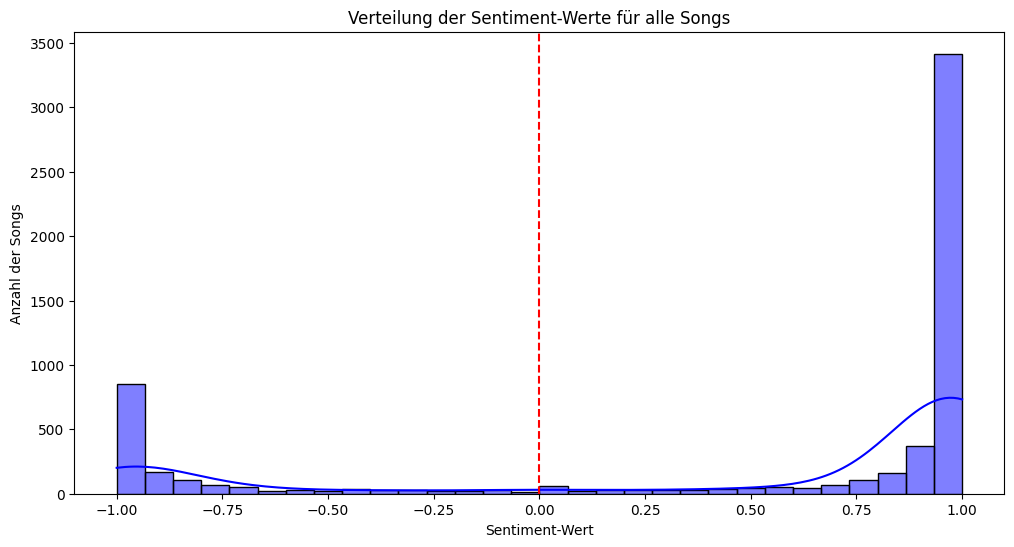

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Angenommen, df3 ist dein DataFrame mit den Spalten 'sentiment' und 'Artist Genres'

# Allgemeine Sentiment-Visualisierung (Histogramm)
plt.figure(figsize=(12, 6))
sns.histplot(df3['sentiment'], bins=30, kde=True, color='blue')
plt.title('Verteilung der Sentiment-Werte für alle Songs')
plt.xlabel('Sentiment-Wert')
plt.ylabel('Anzahl der Songs')
plt.axvline(x=0, color='red', linestyle='--')  # Linie für neutralen Wert
plt.savefig('sentiment.png')
plt.show()

#![Mein Plot](D:/_code/0_DA/Abschlussprojekt/data/sentiment.png)

Die Sentimentanalyse zeigt einen klaren Überhang von positivem Text. 4460 Songs sind über dem Wert von 0.75, nur 779 unter -0.75.

## Fazit

Wir haben einiges an Texten und Themen erkennen können, insgesamt sind die 10.000 ausgewählten Songs ziemlich positiv, oft geht es vor Allem um Liebe, aber auch um Bewegung, Tanzen und Party in den Texten. 

Wir haben gesehen, dass die NMF Analyse weniger Schwankungsanfällig ist und ziemlich gut unterschiedliche Themen herausgefunden hat. 
Wir haben auch gesehen, dass die LDA Analyse teilweise gut voneinander entfernte Cluster bilden konnte und somit auch unterschiedliche Themen gefunden hat. 
Wir haben gesehen, dass es sehr wichtig ist, die richtigen Filter einzusetzen, um unerwünschte Wörter auszublenden, damit sie die Werte nicht verfälschen.

Besonders spannend wäre es, diese Ergebnisse jetzt gegen die sehr große Stichprobe von noch 720.000 Songs von df2 zu stellen, leider ist mein Computer zur Bearbeitung dieser großen Kapazitäten nicht in der Lage. 

# Sprache der Künstler vergleichen

In [34]:
# Suche nach Teilstring „eminem“ (auch innerhalb anderer Texte)
mask_contains = df2["artists"].str.contains(r"eminem", case=False, na=False)
#print(df2[mask_contains])
print(len(df2[mask_contains]))

mask_exact = df2["artists"].str.lower() == "eminem"
#print(df2[mask_exact])
print(len(df2[mask_exact]))

132
38


In [35]:
artist_counts = df2["artists"].value_counts()

# 2. Nimm die 50 häufigsten
top_50 = artist_counts.head(50)

# 3. Ausgabe (DataFrame für hübsche Darstellung)
top_50_df = top_50.reset_index()
top_50_df.columns = ["artist", "count"]
print(top_50_df)

                    artist  count
0      ['Various Artists']   3297
1          Various Artists    637
2            ['Bob Dylan']    540
3         ['Dolly Parton']    489
4        ['Frank Sinatra']    473
5        ['Elvis Presley']    464
6      ['Aretha Franklin']    451
7              Vybz Kartel    418
8                Glee Cast    402
9     ['Guided By Voices']    393
10       ['Fleetwood Mac']    386
11         ['Johnny Cash']    379
12    ['Barbra Streisand']    346
13       ['Willie Nelson']    339
14         ['Dean Martin']    316
15      ['Dionne Warwick']    313
16  ['The Mountain Goats']    303
17            ['The Fall']    301
18       ['Barry Manilow']    299
19      ['Emmylou Harris']    299
20           Elvis Presley    290
21                Alan Tam    282
22     ['Ella Fitzgerald']    281
23              Eason Chan    280
24         ['Udo Jürgens']    277
25  ['The Rolling Stones']    268
26              Sonu Nigam    260
27           ['Pearl Jam']    251
28   ['Vicente